# Project 2: AMES Housing Prices

# Research Question and Background

A company in Ames, Iowa that specializes in flipping houses for resale wishes to understand the factors that affect housing prices and what features they should focus their efforts on improving to ensure the best quality of flipped houses to maximize their profits. On the other hand, they wish to also find the factors that affect the prices of old houses most negatively so that they can avoid purchasing those houses which require more work.

In other words, in the process of maximizing profits, they wish to identify which are good/bad properties, and which areas they should focus on renovating that will improve the housing prices more efficiently.

To answer their research needs, we will be using the [Ames housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) compiled by [Dean De Cock](http://jse.amstat.org/v19n3/decock.pdf), which has 80 features: 23 nominal (unordered categories), 23 ordinal (ordered categories), 14 discrete, and 20 continuous. The full explanation of the features can be found in his [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt). 

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, normaltest
from scipy.stats.mstats import winsorize
from sklearn.impute import KNNImputer

# Loading the Data

In [2]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

# Data Cleaning

Let's first take a look at the data as a whole.

In [3]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

From the info above, we can see there are about 80 features (not excluding ID) with 2051 observations, and a couple of missing values.

We can start by cleaning up the column names. Since both the datasets have a similar column structure, we can create a function to clean them at one go. This function will
1. remove whitespaces at the front and end
2. change whitespaces in the middle to `_`
3. change capitals to lowercase

In [5]:
def pythonic_columns(df):
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(" ", "_")
    df.columns = df.columns.str.lower()

In [6]:
pythonic_columns(train)
train.drop(["id", "pid"], axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ms_subclass      2051 non-null   int64  
 1   ms_zoning        2051 non-null   object 
 2   lot_frontage     1721 non-null   float64
 3   lot_area         2051 non-null   int64  
 4   street           2051 non-null   object 
 5   alley            140 non-null    object 
 6   lot_shape        2051 non-null   object 
 7   land_contour     2051 non-null   object 
 8   utilities        2051 non-null   object 
 9   lot_config       2051 non-null   object 
 10  land_slope       2051 non-null   object 
 11  neighborhood     2051 non-null   object 
 12  condition_1      2051 non-null   object 
 13  condition_2      2051 non-null   object 
 14  bldg_type        2051 non-null   object 
 15  house_style      2051 non-null   object 
 16  overall_qual     2051 non-null   int64  
 17  overall_cond  

In [7]:
pythonic_columns(test)
test.drop(["id", "pid"], axis=1, inplace=True)

For easier access, we can start by grouping related data for a smoother analysis. We can ignore `id` and `pid` because they are simply the identification numbers for the houses.  Based on an observation of the data dictionary, this way of grouping seems to make the most sense:

- inner house data
    - utilities/central air/electrical/heating/heating_qc
    - house style/functional
    - overall qual/cond
    - roof style/matl
    - 1st flr sf/2nd flr sf/low qual fin sf/gr liv area
    - full bath/half bath
    - bedroom_abvgr/kitchen_abvgr/kitchen_qual/totrms_abvgrd
    - fireplaces/fireplace_qu
- outer house data
    - ms subclass/zoning
    - lot frontage/area/shape/config
    - exter qual/cond/condition 1/2/exterior 1/2
    - bldg type/foundation
    - mas vnr type/area
    - fence/paved drive
    - pool area/qc
- location
    - street/alley
    - land contour/slope
    - neighborhood
- deck/porch
    - wood deck sf
    - open porch sf
    - enclosed porch
    - screen porch
    - 3-ssn porch
- basement
    - bsmt qual/cond/exposure/unf sf/total bsmt sf
    - bsmtfin type 1/type 2/sf 1/sf 2
    - bsmt full bath/ half bath
- garage
    - garage type/yr blt/finish/cars/area/qual/cond
- history
    - mo/yr sold/year built/year remod/add
    - sale type/condition
    - **saleprice**
- misc feature
    - misc feature/val

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ms_subclass,2051.0,57.008776,42.824223,20.0,20.0,50.0,70.00,190.0
lot_frontage,1721.0,69.055200,23.260653,21.0,58.0,68.0,80.00,313.0
lot_area,2051.0,10065.208191,6742.488909,1300.0,7500.0,9430.0,11513.50,159000.0
overall_qual,2051.0,6.112140,1.426271,1.0,5.0,6.0,7.00,10.0
overall_cond,2051.0,5.562165,1.104497,1.0,5.0,5.0,6.00,9.0
year_built,2051.0,1971.708922,30.177889,1872.0,1953.5,1974.0,2001.00,2010.0
year_remod/add,2051.0,1984.190151,21.036250,1950.0,1964.5,1993.0,2004.00,2010.0
mas_vnr_area,2029.0,99.695909,174.963129,0.0,0.0,0.0,161.00,1600.0
bsmtfin_sf_1,2050.0,442.300488,461.204124,0.0,0.0,368.0,733.75,5644.0
bsmtfin_sf_2,2050.0,47.959024,165.000901,0.0,0.0,0.0,0.00,1474.0


There seems to be a lot of gaps in the data. We will address these and explain the statistics in detail as we go along.

## Dependent variable

We can first take a look at the properties of the dependent variable - `saleprice`.

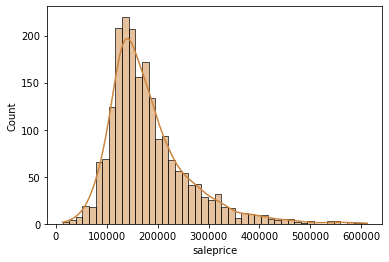

In [9]:
sns.histplot(train["saleprice"], color="peru", kde=True);

We can verify that this feature is very skewed and does not follow a normal distribution very well. The p-value tells us how much the data follows a normal distribution, and the z-test 'statistic' tells us how skewed the data is.

In [10]:
normaltest(train["saleprice"])

NormaltestResult(statistic=627.8409837395818, pvalue=4.635137528865828e-137)

The histogram shows us that the variable is highly skewed, with a number of outliers. We can try to tame this by applying a logarithm on it. 

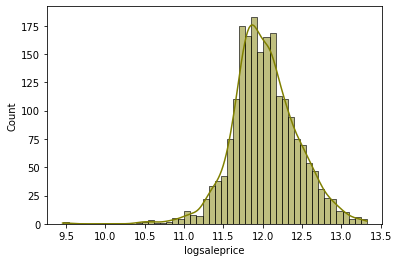

In [11]:
train["logsaleprice"] = np.log(train.saleprice)
sns.histplot(train.logsaleprice, color="olive", kde=True);

When we perform the normaltest again, we can see that the skew is much less and the p-value significantly higher, even though they still do not follow a normal curve yet. But it would make the data easier to analyze.

In [12]:
from scipy.stats import normaltest

normaltest(train.logsaleprice)

NormaltestResult(statistic=98.8573427736384, pvalue=3.415079112898754e-22)

## Data with many missing values

We can choose to remove the features with a 70% and above null-value rate as shown below, but this might remove columns we might need or are collinear. However, with too many missing variables it would be difficult to impute the missing values or draw meaningful conclusions from them. It will also not remove features that have "fake" non-null values like 0 or "nil", which will only be revealed upon closer inspection. Therefore we will examine the these features and how they correlate with the dependent variable, before deciding whether to remove them.

Furthermore we will be plotting heatmaps of the correlation between the features and the dependent variable, and we will take the threshold of $r^2>0.4$ to determine whether to keep the features.

We will define a new variable `train_ohe` to store all our one-hot encoded columns so we do not tamper unnecessarily with `train`.

In [13]:
drop_thresh = train.shape[0] * 0.7
train_ohe = train.dropna(thresh=drop_thresh, how="all", axis=1).copy()

In [14]:
train.columns.difference(train_ohe.columns)

Index(['alley', 'fence', 'fireplace_qu', 'misc_feature', 'pool_qc'], dtype='object')

We can do a brief analysis of these five variables to see if they can be dropped without affecting our data. We can also recall that there are 3 types of missing data:
1. missing completely at random (MCAR): missing data independent of observed/unobserved data
2. missing at random (MAR): missing data dependent on observed but not unobserved data
3. not missing at random (NMAR): missingness is related to events or factors which are not measured by the researcher

### `alley`

The `alley` feature, which gives the type of alley access to the property, would be related to the `street` variable. Since a house that has street access might be related to whether it has alley access, we can group these variables together, and consider the `alley` feature as MAR. In this case, we can examine the relation to the dependent variable with a heatmap.

We will first change the `NaN` values in `alley` to a string 'NA', then perform one-hot encoding on the `alley` column. We can then take a look at the heatmap with respect to the `logsaleprice` feature.

In [15]:
train["alley"].fillna("NA", inplace=True)

In [16]:
train_ohe = pd.get_dummies(train, columns=["alley", "street"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,...,mo_sold,yr_sold,sale_type,saleprice,logsaleprice,alley_Grvl,alley_NA,alley_Pave,street_Grvl,street_Pave
0,60,RL,NaN,13517,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,...,3,2010,WD,130500,11.779129,0,1,0,0,1
1,60,RL,43.0,11492,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,...,4,2009,WD,220000,12.301383,0,1,0,0,1
2,20,RL,68.0,7922,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,1,2010,WD,109000,11.599103,0,1,0,0,1
3,60,RL,73.0,9802,Reg,Lvl,AllPub,Inside,Gtl,Timber,...,4,2010,WD,174000,12.066811,0,1,0,0,1
4,50,RL,82.0,14235,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,...,3,2010,WD,138500,11.838626,0,1,0,0,1


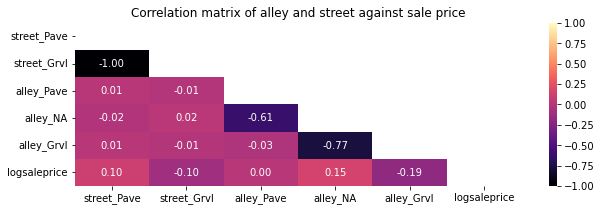

In [17]:
alley_corr = train_ohe.iloc[:, -1:-6:-1]
alley_corr = pd.merge(
    alley_corr, train["logsaleprice"], left_index=True, right_index=True
)
alley_corr = alley_corr.corr()
plt.figure(figsize=(10, 3))
plt.title("Correlation matrix of alley and street against sale price")
mask = np.triu(np.ones_like(alley_corr, dtype=bool))
sns.heatmap(alley_corr, annot=True, fmt=".2f", mask=mask, cmap="magma", vmax=1, vmin=-1);

As we can see, there is a low correlation between the price of the house, the alley access, and street access. We can also plot a histogram showing the frequency of each variable. We can clearly see that the null-values are much more than the other values combined. In this case, we can simply drop both variables.

In [18]:
train["alley"].value_counts()

NA      1911
Grvl      85
Pave      55
Name: alley, dtype: int64

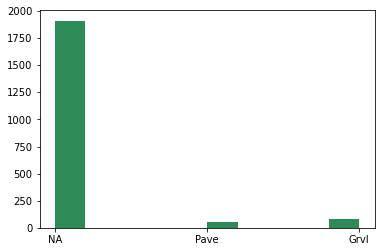

In [19]:
plt.hist(train["alley"], color="seagreen");

### `fence`

We can perform the same operations on the `fence` variable. This seems to be a standalone feature, which might mean it is not very correlated with the others. This is an NMAR feature.

In [20]:
train["fence"].fillna("NA", inplace=True)
train["fence"].value_counts()

NA       1651
MnPrv     227
GdPrv      83
GdWo       80
MnWw       10
Name: fence, dtype: int64

In [21]:
train_ohe = pd.get_dummies(train, columns=["fence"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,mo_sold,yr_sold,sale_type,saleprice,logsaleprice,fence_GdPrv,fence_GdWo,fence_MnPrv,fence_MnWw,fence_NA
0,60,RL,NaN,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,3,2010,WD,130500,11.779129,0,0,0,0,1
1,60,RL,43.0,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,4,2009,WD,220000,12.301383,0,0,0,0,1
2,20,RL,68.0,7922,Pave,NA,Reg,Lvl,AllPub,Inside,...,1,2010,WD,109000,11.599103,0,0,0,0,1
3,60,RL,73.0,9802,Pave,NA,Reg,Lvl,AllPub,Inside,...,4,2010,WD,174000,12.066811,0,0,0,0,1
4,50,RL,82.0,14235,Pave,NA,IR1,Lvl,AllPub,Inside,...,3,2010,WD,138500,11.838626,0,0,0,0,1


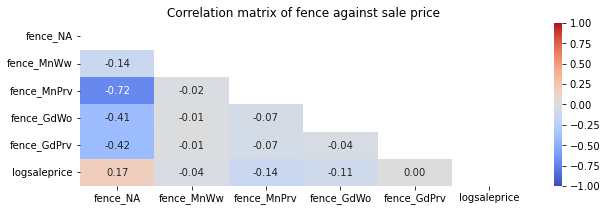

In [22]:
fence_corr = train_ohe.iloc[:, -1:-6:-1]
fence_corr = pd.merge(
    fence_corr, train["logsaleprice"], left_index=True, right_index=True
)
fence_corr = fence_corr.corr()
plt.figure(figsize=(10, 3))
plt.title("Correlation matrix of fence against sale price")
mask = np.triu(np.ones_like(fence_corr, dtype=bool))
sns.heatmap(
    fence_corr, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", vmax=1, vmin=-1
);

We can see clearly that the fence variables have low correlations to the price of the house. Furthermore since there are much more NA values than others, we can safely drop this without much concern.

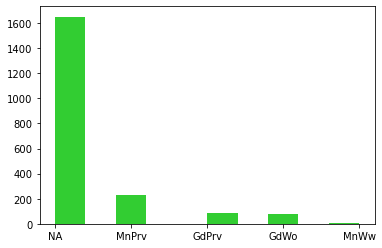

In [23]:
plt.hist(train["fence"], color="limegreen");

### `misc_feature`

The `misc_feature`, related to `misc_val`, contain the types of housing features and their values that were not captured in the other features. These seem like they might not be related to the sale price.

In [24]:
train["misc_feature"].fillna("NA", inplace=True)
train["misc_feature"].value_counts()

NA      1986
Shed      56
Gar2       4
Othr       3
TenC       1
Elev       1
Name: misc_feature, dtype: int64

In [25]:
train[["misc_val", "logsaleprice"]].corr()

,misc_val,logsaleprice
misc_val,1.000000,0.000637
logsaleprice,0.000637,1.000000


Since there are too little values, and they have low correlation with the price of the houses, we will simply drop both features.

### `fireplace_qu`

This feature tracks the quality of the fireplaces in the house. This is dependent on the number of fireplaces in the `fireplaces` feature, and is thus a MAR.

This is an ordinal feature, and we can assign numbers to the values. There is an `OrdinalEncoder` in the `sklearn` library, but that encodes the data alphabetically, which might not be the order we want. It would be better to input the order ourselves. 

We can create one for positive and one for negative values. We can't do this just with the simple `value_counts()` function because it ranks it in descending order of count, which may not be the same as its ordinal order. Thus this has to be keyed in manually based on domain knowledge with reference to the data dictionary.

In [26]:
def desc_ordinal(order):
    """
    given a list of the descending order of the values, converts ordinal values into numerical values in descending order.
    """
    scoring = range(0, -len(order), -1)
    dct = {val: score for val, score in zip(order, scoring)}
    return dct

In [27]:
def asc_ordinal(order):
    """
    given a list of the ascending order of the values, converts ordinal values into numerical values in ascending order.
    """
    scoring = range(0, len(order), 1)
    dct = {val: score for val, score in zip(order, scoring)}
    return dct

In [28]:
fireplace_qu_dict = asc_ordinal([np.nan, "Po", "Fa", "TA", "Gd", "Ex"])
train["fireplace_qu"] = train["fireplace_qu"].map(fireplace_qu_dict)

In [29]:
# verify that the above has been properly done, compare with original
train["fireplace_qu"].value_counts()

0    1000
4     523
3     407
2      59
1      31
5      31
Name: fireplace_qu, dtype: int64

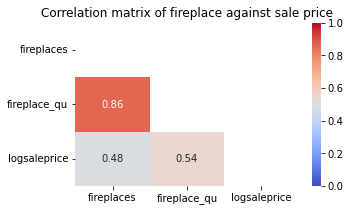

In [30]:
corr = train[["fireplaces", "fireplace_qu", "logsaleprice"]].corr()
plt.figure(figsize=(5, 3))
plt.title("Correlation matrix of fireplace against sale price")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, mask=mask);

As we can see, there is moderate correlation between the two variables and the `saleprice`, and it seems like the fireplace quality is related to the number of fireplaces. We will keep these features for our model.

### `pool_qc`

This feature might be linked to the `pool_area` feature, so we can explore both together.

In [31]:
train["pool_qc"].fillna("NA", inplace=True)
train["pool_qc"].value_counts()

NA    2042
Gd       4
Fa       2
TA       2
Ex       1
Name: pool_qc, dtype: int64

In [32]:
pool_qc_dict = asc_ordinal(["NA", "Fa", "TA", "Gd", "Ex"])
train["pool_qc"] = train["pool_qc"].map(pool_qc_dict)

In [33]:
train["pool_qc"].value_counts()

0    2042
3       4
1       2
2       2
4       1
Name: pool_qc, dtype: int64

In [34]:
train["pool_area"].value_counts()

0      2042
519       1
576       1
800       1
228       1
480       1
648       1
738       1
368       1
561       1
Name: pool_area, dtype: int64

In [35]:
train[["pool_qc", "pool_area", "saleprice"]].corr()

,pool_qc,pool_area,saleprice
pool_qc,1.000000,0.867751,0.030585
pool_area,0.867751,1.000000,0.023106
saleprice,0.030585,0.023106,1.000000


Since there are very few houses with a pool and do not affect the sale prices much, we can drop the columns. A pool can conceivably add to the price of houses, but we have too little data which might cause overfitting in our model. Regrettably we would have to drop these two variables too.

### Summary

In total, we can drop most of the columns which have >70% missing values, except `fireplace_qu` which will be further explored later. We will remove them as we categorize the features below.

There are other features with missing values too, which we can now turn our attention to.

## Missing Values

We first notice that after the cleaning, there are still some missing values. The features with missing values are:
- `bsmt_qual`: null means no basement
- `garage_finish`: null means no garage
- `garage_age`: null means no garage
- `mas_vnr_area`: null means no masonry veneer

### Basement quality

This variable captures the height of the basement, which determines the quality of the basement.

In [36]:
train["bsmt_qual"].value_counts()

TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: bsmt_qual, dtype: int64

In [37]:
train["bsmt_qual"].isnull().sum()

55

From the data dictionary, we see that the null values means that there are no basements. In this case, we can shift the values up by one as we do ordinal encoding, with no basement being 0.

In [38]:
bsmt_dict = asc_ordinal([np.nan, "Po", "Fa", "TA", "Gd", "Ex"])
train["bsmt_qual"] = train["bsmt_qual"].map(bsmt_dict)
train["bsmt_qual"].value_counts()

3    887
4    864
5    184
2     60
0     55
1      1
Name: bsmt_qual, dtype: int64

In [39]:
train["bsmt_qual"].isnull().sum()

0

### Garage finish

In [40]:
train["garage_finish"].value_counts()

Unf    849
RFn    579
Fin    509
Name: garage_finish, dtype: int64

In [41]:
train["garage_finish"].isnull().sum()

114

Again, the null values means that there are no garages. We can perform the same encoding as above.

In [42]:
gar_dict = asc_ordinal([np.nan, "Unf", "RFn", "Fin"])
train["garage_finish"] = train["garage_finish"].map(gar_dict)
train["garage_finish"].value_counts()

1    849
2    579
3    509
0    114
Name: garage_finish, dtype: int64

### Garage year built

The nulls have the same meaning as above, and we can change all the null values to zero. However, due to needing to work with datetime later, we will change it to python's default 0 value for dates.

In [43]:
train["garage_yr_blt"].value_counts().sort_values(ascending=False)

2005.0    105
2007.0     84
2006.0     80
2004.0     72
2003.0     66
         ... 
1918.0      1
2207.0      1
1933.0      1
1895.0      1
1919.0      1
Name: garage_yr_blt, Length: 100, dtype: int64

In [44]:
train["garage_yr_blt"].isnull().sum()

114

Since entering a 0 will throw an error from pandas' `to_datetime()` function, we will input the mean year.

In [45]:
train["garage_yr_blt"].mean()

1978.7077955601446

In [46]:
train["garage_yr_blt"].fillna(1978, inplace=True)
train.garage_yr_blt.value_counts().sort_values()

1919.0      1
1896.0      1
1917.0      1
1895.0      1
2207.0      1
         ... 
2004.0     72
2006.0     80
2007.0     84
2005.0    105
1978.0    147
Name: garage_yr_blt, Length: 100, dtype: int64

However, we see one year that seems to be out of place: 2207.

In [47]:
now = pd.Timestamp("now")
for i in train["garage_yr_blt"]:
    if now.year - i < 0:
        print(i)

2207.0


This means the garage was built in the future, which is clearly wrong. It seems that there was only one wrong imputed value in the `garage_yr_blt` variable. Thus, we can assume that the value was wrongly inputted as 2007. We can correct the imputted value.

In [48]:
train.loc[train["garage_yr_blt"] == 2207, "garage_yr_blt"] = 2007

### Masonry veneer area/type

This variable captures the area/type of masonry veneer, but again not all houses have it. We can impute zero for null values and assume that they do not have any masonry veneer.

In [49]:
train.mas_vnr_area.value_counts().sort_values(ascending=False)

0.0      1216
120.0      11
176.0      10
200.0      10
108.0       9
         ... 
381.0       1
519.0       1
118.0       1
379.0       1
426.0       1
Name: mas_vnr_area, Length: 373, dtype: int64

In [50]:
train["mas_vnr_area"].isnull().sum()

22

In [51]:
train["mas_vnr_area"].fillna(0, inplace=True)

In [52]:
train["mas_vnr_type"].value_counts()

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [53]:
train["mas_vnr_type"].isnull().sum()

22

In [54]:
train["mas_vnr_type"].fillna("None", inplace=True)
train["mas_vnr_type"].value_counts()

None       1240
BrkFace     630
Stone       168
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [55]:
train.mas_vnr_area.value_counts().sort_values(ascending=False)

0.0      1238
120.0      11
176.0      10
200.0      10
108.0       9
         ... 
381.0       1
519.0       1
118.0       1
379.0       1
426.0       1
Name: mas_vnr_area, Length: 373, dtype: int64

### Lot frontage/shape

This feature is slightly different. Every house must have street access, but there are a number of null values.

In [56]:
train["lot_frontage"].isnull().sum()

330

Since this would be an MAR feature, we have to use the k-nearest neighbors imputer to impute values. The features that seem closest to this are lot area and lot shape, which fortunately don't have any null values. We will add to the imputer. However, lot shape is an ordinal variable, which we will need to convert beforehand.

In [57]:
lshape_dict = desc_ordinal(["Reg", 'IR1', 'IR2', 'IR3'])
train["lot_shape"] = train["lot_shape"].map(lshape_dict)
train["lot_shape"].value_counts()

 0    1295
-1     692
-2      55
-3       9
Name: lot_shape, dtype: int64

In [58]:
kimpute = KNNImputer(n_neighbors=10)
train["lot_frontage"] = kimpute.fit_transform(
    train[["lot_frontage", "lot_area", "lot_shape"]]
)

In [59]:
train["lot_frontage"].isnull().sum()

0

In [60]:
train["lot_frontage"].value_counts()

60.0     180
70.0      96
80.0      95
50.0      90
65.0      73
        ... 
74.4       1
115.0      1
82.4       1
93.7       1
83.4       1
Name: lot_frontage, Length: 306, dtype: int64

## Categorizing features

We can now split the features into the categories highlighted above.

In [61]:
inner_house_data = [
    "utilities",
    "house_style",
    "overall_qual",
    "overall_cond",
    "roof_style",
    "roof_matl",
    "heating",
    "heating_qc",
    "central_air",
    "electrical",
    "1st_flr_sf",
    "2nd_flr_sf",
    "low_qual_fin_sf",
    "gr_liv_area",
    "full_bath",
    "half_bath",
    "bedroom_abvgr",
    "kitchen_abvgr",
    "kitchen_qual",
    "totrms_abvgrd",
    "functional",
    "fireplaces",
    "fireplace_qu",
]

In [62]:
outer_house_data = [
    "ms_subclass",
    "ms_zoning",
    "lot_frontage",
    "lot_area",
    "lot_shape",
    "lot_config",
    "condition_1",
    "condition_2",
    "bldg_type",
    "exterior_1st",
    "exterior_2nd",
    "mas_vnr_type",
    "mas_vnr_area",
    "exter_qual",
    "exter_cond",
    "foundation",
    "paved_drive",
]

In [63]:
location = ["land_contour", "land_slope", "neighborhood"]

In [64]:
deck_porch = [
    "wood_deck_sf",
    "open_porch_sf",
    "enclosed_porch",
    "screen_porch",
    "3ssn_porch",
]

In [65]:
basement = [
    "bsmt_qual",
    "bsmt_cond",
    "bsmt_exposure",
    "bsmt_unf_sf",
    "total_bsmt_sf",
    "bsmtfin_type_1",
    "bsmtfin_type_2",
    "bsmtfin_sf_1",
    "bsmtfin_sf_2",
    "bsmt_full_bath",
    "bsmt_half_bath",
]

In [66]:
garage = [
    "garage_type",
    "garage_yr_blt",
    "garage_finish",
    "garage_cars",
    "garage_area",
    "garage_qual",
    "garage_cond",
]

In [67]:
history = ["mo_sold", "yr_sold", "year_built", "year_remod/add", "sale_type"]

In [68]:
# check whether all the variables have been captured
len(inner_house_data) + len(outer_house_data) + len(location) + len(deck_porch) + len(basement) + len(garage) + len(history)

71

## Feature Engineering

Our main strategy would be to encode the ordinals, use one-hot encoding on the nominals, then use a heatmap to visualize the correlations. As mentioned [above](#Data-Cleaning), we will determine the threshold to be a correlation value of 0.4.

### Inner house features

In this category, we examine the features of the house itself. These would, intuitively, be the most important features that affect the prices of the houses.

In [69]:
train[inner_house_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   utilities        2051 non-null   object
 1   house_style      2051 non-null   object
 2   overall_qual     2051 non-null   int64 
 3   overall_cond     2051 non-null   int64 
 4   roof_style       2051 non-null   object
 5   roof_matl        2051 non-null   object
 6   heating          2051 non-null   object
 7   heating_qc       2051 non-null   object
 8   central_air      2051 non-null   object
 9   electrical       2051 non-null   object
 10  1st_flr_sf       2051 non-null   int64 
 11  2nd_flr_sf       2051 non-null   int64 
 12  low_qual_fin_sf  2051 non-null   int64 
 13  gr_liv_area      2051 non-null   int64 
 14  full_bath        2051 non-null   int64 
 15  half_bath        2051 non-null   int64 
 16  bedroom_abvgr    2051 non-null   int64 
 17  kitchen_abvgr    2051 non-null   

In [70]:
train[inner_house_data].head()

,utilities,house_style,overall_qual,overall_cond,roof_style,roof_matl,heating,heating_qc,central_air,electrical,...,gr_liv_area,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu
0,AllPub,2Story,6,8,Gable,CompShg,GasA,Ex,Y,SBrkr,...,1479,2,1,3,1,Gd,6,Typ,0,0
1,AllPub,2Story,7,5,Gable,CompShg,GasA,Ex,Y,SBrkr,...,2122,2,1,4,1,Gd,8,Typ,1,3
2,AllPub,1Story,5,7,Gable,CompShg,GasA,TA,Y,SBrkr,...,1057,1,0,3,1,Gd,5,Typ,0,0
3,AllPub,2Story,5,5,Gable,CompShg,GasA,Gd,Y,SBrkr,...,1444,2,1,3,1,TA,7,Typ,0,0
4,AllPub,1.5Fin,6,8,Gable,CompShg,GasA,TA,Y,SBrkr,...,1445,2,0,3,1,TA,6,Typ,0,0


The column types of the inner house features are:
- utilities/central air/electrical/heating/heating_qc (ordinal/nominal/ordinal/nominal/ordinal)
- house style/functional (nominal/ordinal)
- overall qual/cond (ordinal)
- roof style/matl (nominal)
- 1st flr sf/2nd flr sf/low qual fin sf/gr liv area/totrms_abvgrd (continuous/discrete)
- full bath/half bath (discrete)
- bedroom_abvgr/kitchen_abvgr/kitchen_qual(discrete/discrete/ordinal)
- fireplaces/fireplace_qu (discrete/ordinal)

#### Ordinals

We can first convert the ordinal data to numerical columns for easier analysis, as long as we remember what the numbers reflect.

- The `utilities` column tracks the types of utilities available in a house.

In [71]:
train["utilities"].value_counts()

AllPub    2049
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64

Since there are only 1 instance of houses having no sewage (`NoSewr`) and 1 instance of no sewage and water (`NoSeWr`), these can be considered insignificant. But we shall print the two observations out for future reference.

In [72]:
train[(train["utilities"] == "NoSeWa") | (train["utilities"] == "NoSewr")]

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,logsaleprice
561,20,RL,93.4,14375,Pave,NA,-1,Lvl,NoSeWa,CulDSac,...,0,0,NA,NA,0,1,2009,COD,137500,11.831379
581,30,I (all),109.0,21780,Grvl,NA,0,Lvl,NoSewr,Inside,...,0,0,NA,NA,0,3,2009,ConLD,57625,10.961712


- Now let's take a look at the `functional` feature.

In [73]:
train["functional"].value_counts()

Typ     1915
Min2      42
Min1      42
Mod       29
Maj1      12
Maj2       7
Sev        2
Sal        2
Name: functional, dtype: int64

The `functional` column gives the state of the house in the condition that it is sold. Since this is a 'negative' value, i.e. it is unwanted in a house, we will convert the values into decreasing order from 0.

In [74]:
func_dict = desc_ordinal(["Typ", "Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"])
train["functional"] = train["functional"].map(func_dict)

In [75]:
# verify that the above has been properly done
train["functional"].value_counts()

 0    1915
-2      42
-1      42
-3      29
-4      12
-5       7
-6       2
-7       2
Name: functional, dtype: int64

- We can transform the other 2 ordinal columns: `kitchen_qual` and `heating_qc`.

In [76]:
train["kitchen_qual"].value_counts()

TA    1047
Gd     806
Ex     151
Fa      47
Name: kitchen_qual, dtype: int64

In [77]:
kitchen_qu_dict = asc_ordinal(["Fa", "TA", "Gd", "Ex"])
kitchen_qu_dict

{'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}

In [78]:
train["kitchen_qual"] = train["kitchen_qual"].map(kitchen_qu_dict)
train["kitchen_qual"].value_counts()

1    1047
2     806
3     151
0      47
Name: kitchen_qual, dtype: int64

In [79]:
train["heating_qc"].value_counts()

Ex    1065
TA     597
Gd     319
Fa      67
Po       3
Name: heating_qc, dtype: int64

In [80]:
heating_qc_dict = asc_ordinal(["Po", "Fa", "TA", "Gd", "Ex"])
heating_qc_dict

{'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}

In [81]:
train["heating_qc"] = train["heating_qc"].map(heating_qc_dict)
train["heating_qc"].value_counts()

4    1065
2     597
3     319
1      67
0       3
Name: heating_qc, dtype: int64

Since the `overall_qual` and `overall_cond` variables are already integers, we don't need to change them.

We can then look at the other data to see if any features can be combined to simplify our analysis.

#### Quality and condition: overall qual/cond (ordinal)

We can first consider the quality and condition of the house to see if they are related.

In [82]:
overall = ["overall_qual", "overall_cond"]

In [83]:
train[overall].head()

,overall_qual,overall_cond
0,6,8
1,7,5
2,5,7
3,5,5
4,6,8


In [84]:
train[overall].describe().T

,count,mean,std,min,25%,50%,75%,max
overall_qual,2051.0,6.112140,1.426271,1.0,5.0,6.0,7.0,10.0
overall_cond,2051.0,5.562165,1.104497,1.0,5.0,5.0,6.0,9.0


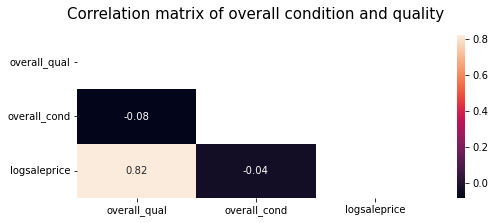

In [85]:
overall_corr = pd.merge(
    train[overall], train["logsaleprice"], left_index=True, right_index=True
).corr()
mask = np.triu(np.ones_like(overall_corr, dtype=bool))
plt.figure(figsize=(8, 3))
heatmap = sns.heatmap(overall_corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of overall condition and quality",
    fontdict={"fontsize": 15},
    pad=16,
);

The overall condition of the house seems to have little impact on the sale price of the house, whereas the overall quality has a high impact. This makes sense as the condition of the original house doesn't matter if it is will be done up anyway, but the quality of the material and finish affect the durability and appearance of a house which is what buyers look out for. We can then drop the `overall_cond` feature.

In [86]:
inner_house_data.remove("overall_cond")

#### Utilities: utilities/central air/electrical/heating/heating_qc (ordinal/nominal/ordinal/nominal/ordinal)

In [87]:
utils = ["utilities", "central_air", "electrical", "heating", "heating_qc"]

In [88]:
train[utils].head()

,utilities,central_air,electrical,heating,heating_qc
0,AllPub,Y,SBrkr,GasA,4
1,AllPub,Y,SBrkr,GasA,4
2,AllPub,Y,SBrkr,GasA,2
3,AllPub,Y,SBrkr,GasA,3
4,AllPub,Y,SBrkr,GasA,2


In [89]:
for i in utils:
    print(train[i].value_counts())

AllPub    2049
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64
Y    1910
N     141
Name: central_air, dtype: int64
SBrkr    1868
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: electrical, dtype: int64
GasA    2018
GasW      20
Wall       6
Grav       5
OthW       2
Name: heating, dtype: int64
4    1065
2     597
3     319
1      67
0       3
Name: heating_qc, dtype: int64


As seen [above](#Ordinals), the `utilities` feature has only 2 values which differ from the norm. These were explored above.

The `central_air` variable can be binarized.

In [90]:
binary = asc_ordinal(["N", "Y"])
train["central_air"] = train["central_air"].map(binary)
train["central_air"].value_counts()

1    1910
0     141
Name: central_air, dtype: int64

The `electrical` and `heating` variable, being nominal, have to be one-hot encoded.

In [91]:
train_ohe = pd.get_dummies(train_ohe, columns=["electrical", "heating"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,electrical_FuseA,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall
0,60,RL,NaN,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,1,1,0,0,0,0
1,60,RL,43.0,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,1,1,0,0,0,0
2,20,RL,68.0,7922,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,0,1,1,0,0,0,0
3,60,RL,73.0,9802,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,0,1,1,0,0,0,0
4,50,RL,82.0,14235,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,0,0,1,1,0,0,0,0


In [92]:
util_corr = train_ohe.iloc[:, -1:-11:-1]
util_corr = pd.merge(
    util_corr,
    train[["heating_qc", "central_air", "logsaleprice"]],
    left_index=True,
    right_index=True,
)
util_corr.describe().T

,count,mean,std,min,25%,50%,75%,max
heating_Wall,2051.0,0.002925,0.054021,0.000000,0.000000,0.000000,0.000000,1.000000
heating_OthW,2051.0,0.000975,0.031220,0.000000,0.000000,0.000000,0.000000,1.000000
heating_Grav,2051.0,0.002438,0.049326,0.000000,0.000000,0.000000,0.000000,1.000000
heating_GasW,2051.0,0.009751,0.098290,0.000000,0.000000,0.000000,0.000000,1.000000
heating_GasA,2051.0,0.983910,0.125851,0.000000,1.000000,1.000000,1.000000,1.000000
electrical_SBrkr,2051.0,0.910775,0.285137,0.000000,1.000000,1.000000,1.000000,1.000000
electrical_Mix,2051.0,0.000488,0.022081,0.000000,0.000000,0.000000,0.000000,1.000000
electrical_FuseP,2051.0,0.003413,0.058335,0.000000,0.000000,0.000000,0.000000,1.000000
electrical_FuseF,2051.0,0.017065,0.129545,0.000000,0.000000,0.000000,0.000000,1.000000
electrical_FuseA,2051.0,0.068259,0.252252,0.000000,0.000000,0.000000,0.000000,1.000000


We can see that most houses have central air-conditioning and good heating.

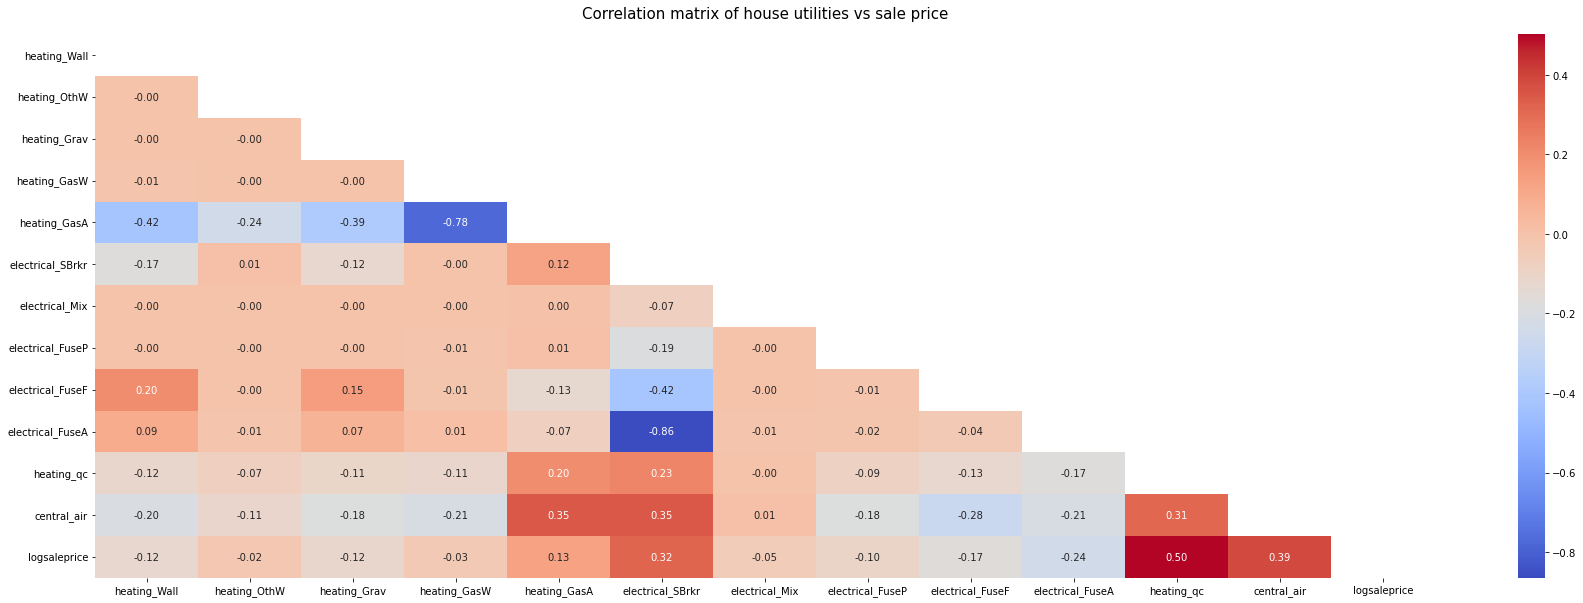

In [93]:
corr = util_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap='coolwarm')
heatmap.set_title(
    "Correlation matrix of house utilities vs sale price",
    fontdict={"fontsize": 15},
    pad=16,
);

From the correlation matrix, we can see that the quality of heating and the central air-conditioning have a moderate correlation with the sale price. Interestingly, the type of heating has low correlation with the sale price. We can explore these in more detail. But first, we can drop the rest of the columns.

In [94]:
inner_house_data.remove("heating")
inner_house_data.remove("electrical")
inner_house_data.remove("utilities")

For ordinal data, we can perform a [spearman correlation](https://towardsdatascience.com/discover-the-strength-of-monotonic-relation-850d11f72046) to determine the relationship between continuous and ordinal data.

In [95]:
train[["heating_qc", "central_air", "logsaleprice"]].corr(method="spearman")

,heating_qc,central_air,logsaleprice
heating_qc,1.000000,0.289472,0.518756
central_air,0.289472,1.000000,0.339395
logsaleprice,0.518756,0.339395,1.000000


In this case, the central air-conditioning variable falls off whilst the quality of the heating remains strong. We will thus keep the `heating_qc` variable.

In [96]:
inner_house_data.remove("central_air")

#### Gross Floor Area: 1st flr sf/2nd flr sf/low qual fin sf/gr liv area/totrms_abvgrd (continuous/discrete)

In [97]:
gfa = ["1st_flr_sf", "2nd_flr_sf", "low_qual_fin_sf", "gr_liv_area", "totrms_abvgrd"]

In [98]:
train[gfa].head()

,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,totrms_abvgrd
0,725,754,0,1479,6
1,913,1209,0,2122,8
2,1057,0,0,1057,5
3,744,700,0,1444,7
4,831,614,0,1445,6


In [99]:
train[gfa].describe().T

,count,mean,std,min,25%,50%,75%,max
1st_flr_sf,2051.0,1164.488055,396.446923,334.0,879.5,1093.0,1405.0,5095.0
2nd_flr_sf,2051.0,329.329108,425.671046,0.0,0.0,0.0,692.5,1862.0
low_qual_fin_sf,2051.0,5.512921,51.068870,0.0,0.0,0.0,0.0,1064.0
gr_liv_area,2051.0,1499.330083,500.447829,334.0,1129.0,1444.0,1728.5,5642.0
totrms_abvgrd,2051.0,6.435885,1.560225,2.0,5.0,6.0,7.0,15.0


We can see that the mean for the first three features add up to that of the gross living area. We can also see that the standard deviations for the gross floor area and total rooms are moderately small.

Since housing prices would be very correlated to the gross living area, we can find a variable that represents this. It would seem that the 1st floor and 2nd floor square feet would be correlated to the ground living area, which we can perform a check to verify.

In [100]:
living_area = train["1st_flr_sf"] + train["2nd_flr_sf"] + train["low_qual_fin_sf"]
(living_area == train["gr_liv_area"]).value_counts()

True    2051
dtype: int64

It would seem that they are exactly the same. Since it would be prudent to simply use the data collected, we can perform a correlation check on the relevant columns.

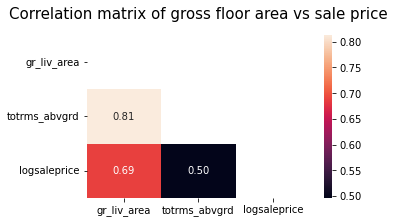

In [101]:
corr = train[["gr_liv_area", "totrms_abvgrd", "logsaleprice"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(5, 3))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of gross floor area vs sale price",
    fontdict={"fontsize": 15},
    pad=16,
);

As expected, these variables are moderately to highly correlated, and we can drop the irrelevant ones.

In [102]:
inner_house_data.remove("1st_flr_sf")
inner_house_data.remove("2nd_flr_sf")
inner_house_data.remove("low_qual_fin_sf")

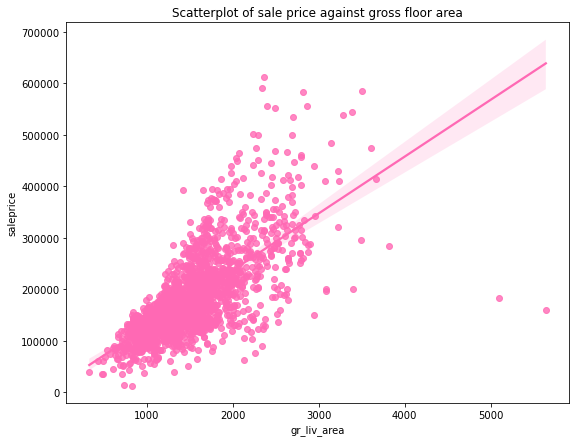

In [103]:
plt.figure(figsize=(9, 7))
plt.title("Scatterplot of sale price against gross floor area")
sns.regplot(x=train["gr_liv_area"], y=train["saleprice"], color="hotpink");

The data dictionary recommends removing houses with gross living areas of above 4000 which would remove most outliers, so we can proceed to remove them.

In [104]:
train = train[train["gr_liv_area"] <= 4000]

#### House Style: house style/functional (nominal/ordinal)

In [105]:
housestyle = ["house_style", "functional"]

Since the `house_style` feature is nominal while `functional` is ordinal, we can perform a one-hot encoding on the former.

In [106]:
train_ohe = pd.get_dummies(train_ohe, columns=["house_style"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,heating_OthW,heating_Wall,house_style_1.5Fin,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl
0,60,RL,NaN,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,0,0,1,0,0
1,60,RL,43.0,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,0,0,1,0,0
2,20,RL,68.0,7922,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,0,1,0,0,0,0,0
3,60,RL,73.0,9802,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,0,1,0,0
4,50,RL,82.0,14235,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,1,0,0,0,0,0,0,0


In [107]:
style_corr = train_ohe.iloc[:, -1:-9:-1]
style_corr = pd.merge(
    style_corr, train[["functional", "logsaleprice"]], left_index=True, right_index=True
)
style_corr.describe().T

,count,mean,std,min,25%,50%,75%,max
house_style_SLvl,2049.0,0.045876,0.209267,0.000000,0.00000,0.000000,0.000000,1.000000
house_style_SFoyer,2049.0,0.024402,0.154332,0.000000,0.00000,0.000000,0.000000,1.000000
house_style_2Story,2049.0,0.291362,0.454501,0.000000,0.00000,0.000000,1.000000,1.000000
house_style_2.5Unf,2049.0,0.006833,0.082397,0.000000,0.00000,0.000000,0.000000,1.000000
house_style_2.5Fin,2049.0,0.002928,0.054047,0.000000,0.00000,0.000000,0.000000,1.000000
house_style_1Story,2049.0,0.516349,0.499855,0.000000,0.00000,1.000000,1.000000,1.000000
house_style_1.5Unf,2049.0,0.005857,0.076322,0.000000,0.00000,0.000000,0.000000,1.000000
house_style_1.5Fin,2049.0,0.106393,0.308416,0.000000,0.00000,0.000000,0.000000,1.000000
functional,2049.0,-0.157150,0.683725,-7.000000,0.00000,0.000000,0.000000,0.000000
logsaleprice,2049.0,12.024370,0.411511,9.456341,11.77375,11.998433,12.273731,13.323927


About half the houses are single story houses, and most of them are relatively functional with some minor deductions.

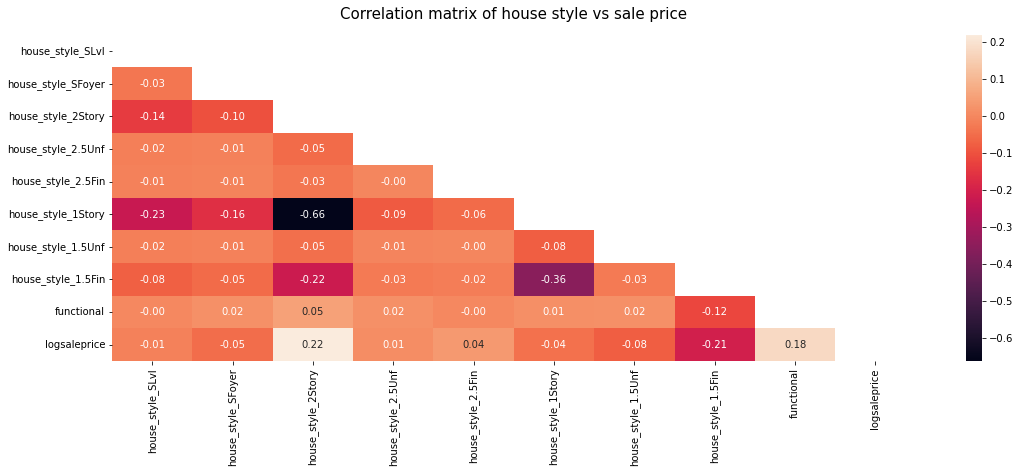

In [108]:
corr = style_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(18, 6))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of house style vs sale price", fontdict={"fontsize": 15}, pad=16
);

As we can see, these variables are lowly correlated. We can drop them.

In [109]:
inner_house_data.remove("house_style")
inner_house_data.remove("functional")

#### Roof Style: roof style/matl (nominal)

In [110]:
roof = ["roof_style", "roof_matl"]

In [111]:
for i in roof:
    print(train[i].value_counts())

Gable      1619
Hip         395
Flat         13
Gambrel      12
Mansard       7
Shed          3
Name: roof_style, dtype: int64
CompShg    2024
Tar&Grv      15
WdShngl       5
WdShake       4
Membran       1
Name: roof_matl, dtype: int64


In [112]:
train_ohe = pd.get_dummies(train_ohe, columns=roof)
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,roof_matl_ClyTile,roof_matl_CompShg,roof_matl_Membran,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl
0,60,RL,NaN,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,1,0,0,0,0
1,60,RL,43.0,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,1,0,0,0,0
2,20,RL,68.0,7922,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,1,0,0,0,0
3,60,RL,73.0,9802,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,1,0,0,0,0
4,50,RL,82.0,14235,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,1,0,0,0,0


In [113]:
roof_corr = train_ohe.iloc[:, -1:-13:-1]
roof_corr = pd.merge(
    roof_corr, train["logsaleprice"], left_index=True, right_index=True
)
roof_corr.describe().T

,count,mean,std,min,25%,50%,75%,max
roof_matl_WdShngl,2049.0,0.002440,0.049350,0.000000,0.00000,0.000000,0.000000,1.000000
roof_matl_WdShake,2049.0,0.001952,0.044151,0.000000,0.00000,0.000000,0.000000,1.000000
roof_matl_Tar&Grv,2049.0,0.007321,0.085268,0.000000,0.00000,0.000000,0.000000,1.000000
roof_matl_Membran,2049.0,0.000488,0.022092,0.000000,0.00000,0.000000,0.000000,1.000000
roof_matl_CompShg,2049.0,0.987799,0.109809,0.000000,1.00000,1.000000,1.000000,1.000000
roof_matl_ClyTile,2049.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
roof_style_Shed,2049.0,0.001464,0.038245,0.000000,0.00000,0.000000,0.000000,1.000000
roof_style_Mansard,2049.0,0.003416,0.058363,0.000000,0.00000,0.000000,0.000000,1.000000
roof_style_Hip,2049.0,0.192777,0.394576,0.000000,0.00000,0.000000,0.000000,1.000000
roof_style_Gambrel,2049.0,0.005857,0.076322,0.000000,0.00000,0.000000,0.000000,1.000000


Most of the roof materials are made of composite shingle, and/or are gable roofs. 

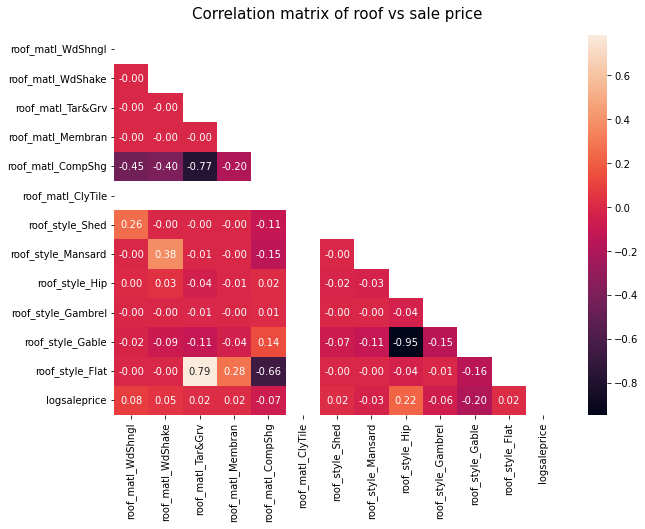

In [114]:
corr = roof_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of roof vs sale price", fontdict={"fontsize": 15}, pad=16
);

There seems to be a missing column. Upon further inspection, there is only 1 value for this feature. We can ignore it.

In [115]:
train_ohe["roof_matl_ClyTile"].value_counts()

0    2050
1       1
Name: roof_matl_ClyTile, dtype: int64

None of the variables are strongly correlated, and we can remove them from the data.

In [116]:
inner_house_data.remove("roof_matl")
inner_house_data.remove("roof_style")

#### Bath: full bath/half bath (discrete)

In [117]:
bath = ["full_bath", "half_bath", "logsaleprice"]

In [118]:
for i in bath:
    print(train[i].value_counts())

2    1094
1     900
3      45
0       8
4       2
Name: full_bath, dtype: int64
0    1308
1     723
2      18
Name: half_bath, dtype: int64
11.775290    25
11.849398    22
11.884489    20
11.813030    19
12.043554    16
             ..
11.598727     1
12.216023     1
12.428015     1
11.914048     1
12.607366     1
Name: logsaleprice, Length: 827, dtype: int64


In [119]:
train[bath].corr()

,full_bath,half_bath,logsaleprice
full_bath,1.000000,0.152874,0.565977
half_bath,0.152874,1.000000,0.300695
logsaleprice,0.565977,0.300695,1.000000


As we can see, the number of full bathrooms have a strong correlation with the sale price, but not the half baths.

In [120]:
train[bath].describe().T

,count,mean,std,min,25%,50%,75%,max
full_bath,2049.0,1.576867,0.549389,0.000000,1.00000,2.000000,2.000000,4.000000
half_bath,2049.0,0.370425,0.500901,0.000000,0.00000,0.000000,1.000000,2.000000
logsaleprice,2049.0,12.024370,0.411511,9.456341,11.77375,11.998433,12.273731,13.323927


It seems that most houses have at least 1 full bath, while not many have half-baths. We can remove this feature.

In [121]:
inner_house_data.remove("half_bath")

#### Bedroom/kitchen: bedroom_abvgr/kitchen_abvgr/kitchen_qual (discrete/discrete/ordinal)

In [122]:
bedrm = ["bedroom_abvgr", "kitchen_abvgr", "kitchen_qual"]

In [123]:
train[bedrm].describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom_abvgr,2049.0,2.843826,0.826804,0.0,2.0,3.0,3.0,8.0
kitchen_abvgr,2049.0,1.042948,0.209888,0.0,1.0,1.0,1.0,3.0
kitchen_qual,2049.0,1.515861,0.664287,0.0,1.0,1.0,2.0,3.0


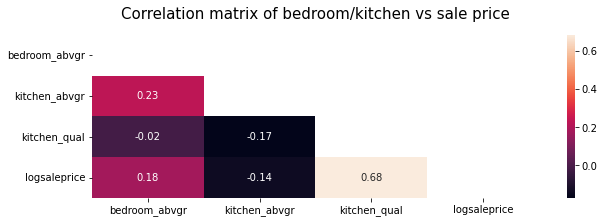

In [124]:
corr = style_corr = pd.merge(
    train[bedrm], train["logsaleprice"], left_index=True, right_index=True
).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 3))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of bedroom/kitchen vs sale price",
    fontdict={"fontsize": 15},
    pad=16,
);

Only the kitchen quality has a strong correlation, and we can remove the rest.

In [125]:
inner_house_data.remove("bedroom_abvgr")
inner_house_data.remove("kitchen_abvgr")

#### Fireplace: fireplaces/fireplace_qu (discrete/ordinal)

This was already explored [earlier](#fireplace_qu), and we saw that there is a moderately high relation between these two variables and sale price. We can explore combining these variables together to see if they can be combined.

In [126]:
firepl = ["fireplaces", "fireplace_qu"]

In [127]:
train[firepl].corr()

,fireplaces,fireplace_qu
fireplaces,1.000000,0.860785
fireplace_qu,0.860785,1.000000


The feature is extremely skewed. We cannot apply a log transform to tame the outliers because of the many 0 values. We will have to leave it, and see if it is correlated to the sale prices.

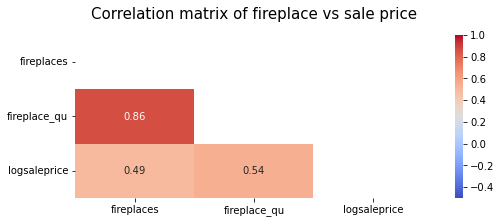

In [128]:
corr = pd.merge(
    train[firepl], train["logsaleprice"], left_index=True, right_index=True
).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 3))
heatmap = sns.heatmap(
    corr, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", vmax=1, vmin=-0.5
)
heatmap.set_title(
    "Correlation matrix of fireplace vs sale price", fontdict={"fontsize": 15}, pad=16
);

These two features meet our criteria, and we will keep both of them.

#### Summary

In summary, we are only left with 7 features from the inner house data. This should suffice for our model.

In [129]:
inner_house_data

['overall_qual',
 'heating_qc',
 'gr_liv_area',
 'full_bath',
 'kitchen_qual',
 'totrms_abvgrd',
 'fireplaces',
 'fireplace_qu']

### Outer house features

In this category, we examine the features of the exterior of the house. These would also be important features that affect housing prices.

In [130]:
train[outer_house_data].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ms_subclass   2049 non-null   int64  
 1   ms_zoning     2049 non-null   object 
 2   lot_frontage  2049 non-null   float64
 3   lot_area      2049 non-null   int64  
 4   lot_shape     2049 non-null   int64  
 5   lot_config    2049 non-null   object 
 6   condition_1   2049 non-null   object 
 7   condition_2   2049 non-null   object 
 8   bldg_type     2049 non-null   object 
 9   exterior_1st  2049 non-null   object 
 10  exterior_2nd  2049 non-null   object 
 11  mas_vnr_type  2049 non-null   object 
 12  mas_vnr_area  2049 non-null   float64
 13  exter_qual    2049 non-null   object 
 14  exter_cond    2049 non-null   object 
 15  foundation    2049 non-null   object 
 16  paved_drive   2049 non-null   object 
dtypes: float64(2), int64(3), object(12)
memory usage: 352.7+ KB


In [131]:
train[outer_house_data].head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,lot_shape,lot_config,condition_1,condition_2,bldg_type,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,paved_drive
0,60,RL,87.9,13517,-1,CulDSac,RRAe,Norm,1Fam,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,Y
1,60,RL,43.0,11492,-1,CulDSac,Norm,Norm,1Fam,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Y
2,20,RL,68.0,7922,0,Inside,Norm,Norm,1Fam,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,Y
3,60,RL,73.0,9802,0,Inside,Norm,Norm,1Fam,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Y
4,50,RL,82.0,14235,-1,Inside,Norm,Norm,1Fam,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,N


The column types of the outer house features are:
- ms subclass/zoning (nominal)
- lot frontage/area/shape/config (continuous/contiunuos/ordinal/nominal)
- exter qual/cond/condition 1/2/exterior 1/2 (ordinal/nominal)
- bldg type/foundation (nominal)
- mas vnr type/area (nominal/continuous)
- fence/paved drive (ordinal)

#### General: ms subclass/zoning (nominal)

In [132]:
gen = ["ms_subclass", "ms_zoning"]

In [133]:
for i in gen:
    print(train[i].value_counts())

20     769
60     393
50     198
120    132
30     101
70      90
160     88
80      86
90      75
190     46
85      28
75      16
180     11
45      11
40       4
150      1
Name: ms_subclass, dtype: int64
RL         1596
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64


In [134]:
train_ohe = pd.get_dummies(train_ohe, columns=gen)
train_ohe.head()

,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,...,ms_subclass_160,ms_subclass_180,ms_subclass_190,ms_zoning_A (agr),ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM
0,NaN,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,...,0,0,0,0,0,0,0,0,1,0
1,43.0,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,...,0,0,0,0,0,0,0,0,1,0
2,68.0,7922,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,0,0,0,1,0
3,73.0,9802,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,...,0,0,0,0,0,0,0,0,1,0
4,82.0,14235,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,...,0,0,0,0,0,0,0,0,1,0


In [135]:
gen_corr = train_ohe.iloc[:, -1:-24:-1]
gen_corr = pd.merge(gen_corr, train["logsaleprice"], left_index=True, right_index=True)
gen_corr.describe().T

,count,mean,std,min,25%,50%,75%,max
ms_zoning_RM,2049.0,0.154222,0.361249,0.000000,0.00000,0.000000,0.000000,1.000000
ms_zoning_RL,2049.0,0.778917,0.415078,0.000000,1.00000,1.000000,1.000000,1.000000
ms_zoning_RH,2049.0,0.006833,0.082397,0.000000,0.00000,0.000000,0.000000,1.000000
ms_zoning_I (all),2049.0,0.000488,0.022092,0.000000,0.00000,0.000000,0.000000,1.000000
ms_zoning_FV,2049.0,0.049292,0.216531,0.000000,0.00000,0.000000,0.000000,1.000000
ms_zoning_C (all),2049.0,0.009273,0.095871,0.000000,0.00000,0.000000,0.000000,1.000000
ms_zoning_A (agr),2049.0,0.000976,0.031235,0.000000,0.00000,0.000000,0.000000,1.000000
ms_subclass_190,2049.0,0.022450,0.148178,0.000000,0.00000,0.000000,0.000000,1.000000
ms_subclass_180,2049.0,0.005368,0.073091,0.000000,0.00000,0.000000,0.000000,1.000000
ms_subclass_160,2049.0,0.042948,0.202789,0.000000,0.00000,0.000000,0.000000,1.000000


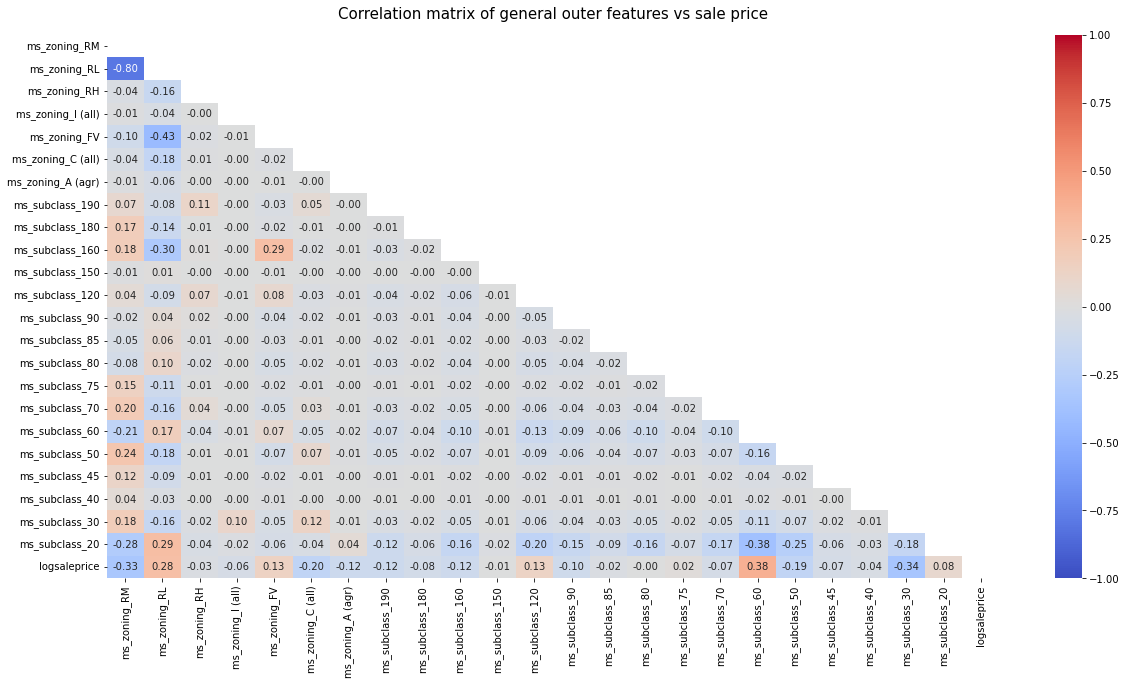

In [136]:
corr = gen_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(
    corr, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", vmin=-1, vmax=1
)
heatmap.set_title(
    "Correlation matrix of general outer features vs sale price",
    fontdict={"fontsize": 15},
    pad=16,
);

None of the variables are strongly correlated, and we can remove them.

In [137]:
for i in gen:
    outer_house_data.remove(i)

#### Lot: lot frontage/area/shape/config (continuous/continuous/ordinal/nominal)

In [138]:
lot = ["lot_area", "lot_frontage", "lot_shape", "lot_config"]

In [139]:
train_ohe = pd.get_dummies(train, columns=["lot_config"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,land_slope,...,mo_sold,yr_sold,sale_type,saleprice,logsaleprice,lot_config_Corner,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside
0,60,RL,87.9,13517,Pave,NA,-1,Lvl,AllPub,Gtl,...,3,2010,WD,130500,11.779129,0,1,0,0,0
1,60,RL,43.0,11492,Pave,NA,-1,Lvl,AllPub,Gtl,...,4,2009,WD,220000,12.301383,0,1,0,0,0
2,20,RL,68.0,7922,Pave,NA,0,Lvl,AllPub,Gtl,...,1,2010,WD,109000,11.599103,0,0,0,0,1
3,60,RL,73.0,9802,Pave,NA,0,Lvl,AllPub,Gtl,...,4,2010,WD,174000,12.066811,0,0,0,0,1
4,50,RL,82.0,14235,Pave,NA,-1,Lvl,AllPub,Gtl,...,3,2010,WD,138500,11.838626,0,0,0,0,1


In [140]:
lot_corr = train_ohe.iloc[:, -1:-5:-1]
lot_corr = pd.merge(
    lot_corr,
    train[["lot_frontage", "lot_area", "lot_shape", "logsaleprice"]],
    left_index=True,
    right_index=True,
)
lot_corr.describe().T

,count,mean,std,min,25%,50%,75%,max
lot_config_Inside,2049.0,0.733041,0.442479,0.000000,0.00000,1.000000,1.000000,1.000000
lot_config_FR3,2049.0,0.004392,0.066146,0.000000,0.00000,0.000000,0.000000,1.000000
lot_config_FR2,2049.0,0.029283,0.168639,0.000000,0.00000,0.000000,0.000000,1.000000
lot_config_CulDSac,2049.0,0.063934,0.244694,0.000000,0.00000,0.000000,0.000000,1.000000
lot_frontage,2049.0,69.831088,21.850990,21.000000,60.00000,70.000000,81.000000,313.000000
lot_area,2049.0,10024.677892,6608.511749,1300.000000,7500.00000,9405.000000,11500.000000,159000.000000
lot_shape,2049.0,-0.402635,0.563725,-3.000000,-1.00000,0.000000,0.000000,0.000000
logsaleprice,2049.0,12.024370,0.411511,9.456341,11.77375,11.998433,12.273731,13.323927


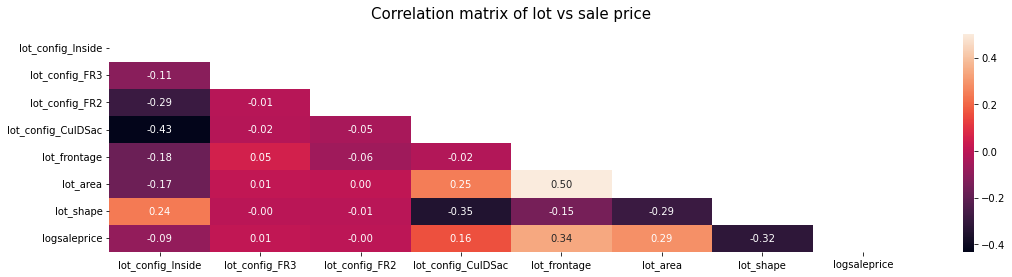

In [141]:
corr = lot_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(18, 4))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of lot vs sale price", fontdict={"fontsize": 15}, pad=16
);

As we can see, the area, shape, and frontage of the lot might play a part in the sale price. We can explore them further.

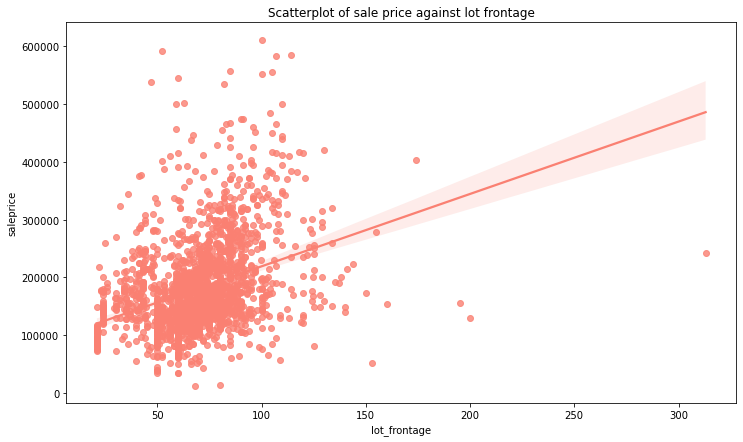

In [142]:
plt.figure(figsize=(12, 7))
plt.title("Scatterplot of sale price against lot frontage")
sns.regplot(x=train["lot_frontage"], y=train["saleprice"], color="salmon");

There are a few obvious outliers in the lot frontage variable. We can try to plot the feature out to look at its properties.

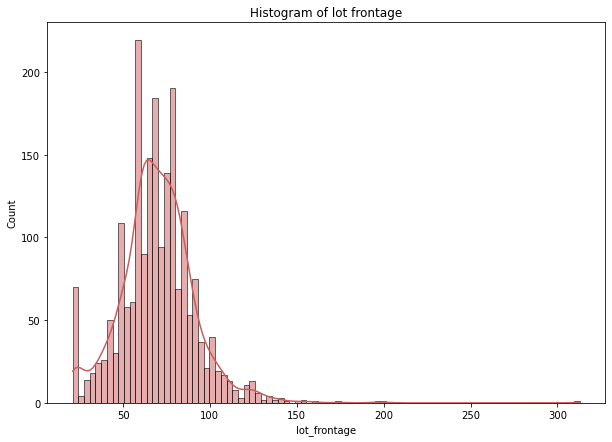

In [143]:
plt.figure(figsize=(10, 7))
plt.title("Histogram of lot frontage")
sns.histplot(x=train["lot_frontage"], color="indianred", kde=True);

In [144]:
normaltest(train["lot_frontage"])

NormaltestResult(statistic=634.0556020487684, pvalue=2.0728859370189213e-138)

The normal test shows that it is not normal at all, and heavily skewed. This can be more clearly seen in a boxplot.

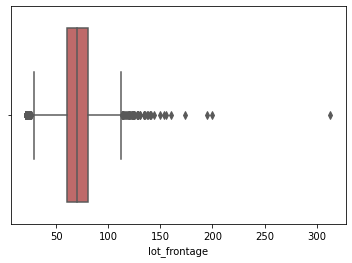

In [145]:
sns.boxplot(x=train["lot_frontage"], color="indianred");

The feature has a lot of outliers. We can try two methods to deal with them: winsorize and a logarithmic transform.

[Winsorization](https://www.statology.org/winsorize/) takes the outlier values beyond a certain set limit and sets them at that value.

In [146]:
train_ohe["lfw"] = winsorize(train["lot_frontage"], limits=0.05)

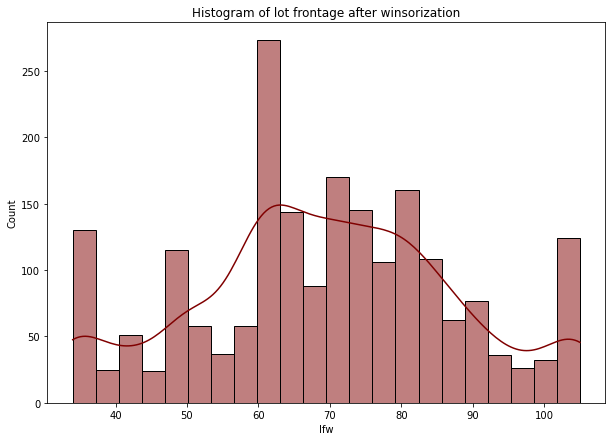

In [147]:
plt.figure(figsize=(10, 7))
plt.title("Histogram of lot frontage after winsorization")
sns.histplot(x=train_ohe["lfw"], color="maroon", kde=True);

In [148]:
normaltest(train_ohe["lfw"])

NormaltestResult(statistic=30.13061013174476, pvalue=2.8656367737976806e-07)

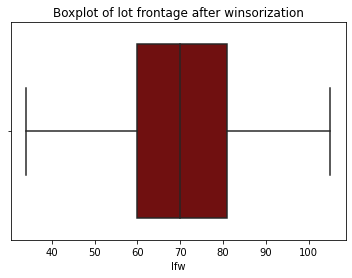

In [149]:
plt.title("Boxplot of lot frontage after winsorization")
sns.boxplot(x=train_ohe["lfw"], color="maroon");

As we can see, the skew is reduced drastically and the p-value still remains low but is much higher than the original value. We will try a log transform next.

In [150]:
train_ohe["log_lf"] = np.log(train["lot_frontage"])

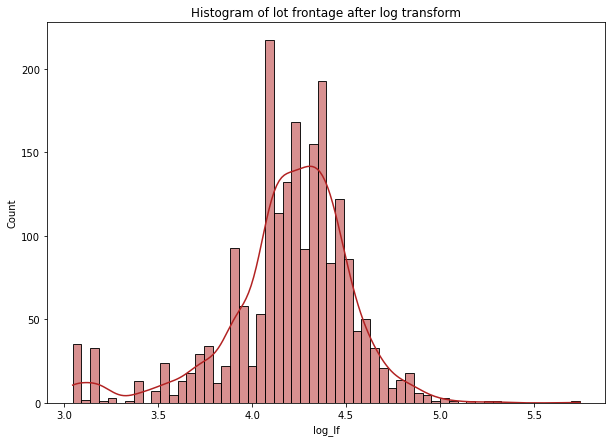

In [151]:
plt.figure(figsize=(10, 7))
plt.title("Histogram of lot frontage after log transform")
sns.histplot(x=train_ohe["log_lf"], color="firebrick", kde=True);

In [152]:
normaltest(train_ohe["log_lf"])

NormaltestResult(statistic=367.21357539679155, pvalue=1.822154771425791e-80)

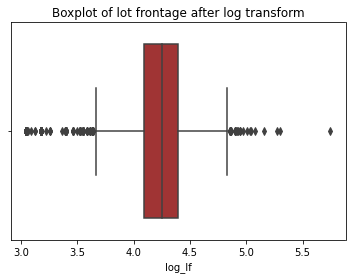

In [153]:
plt.title("Boxplot of lot frontage after log transform")
sns.boxplot(x=train_ohe["log_lf"], color="firebrick");

In the end, the winsorization worked the best as it reduced all the skew while making the data more normal. We can take a look at lot area and lot shape in the same way.

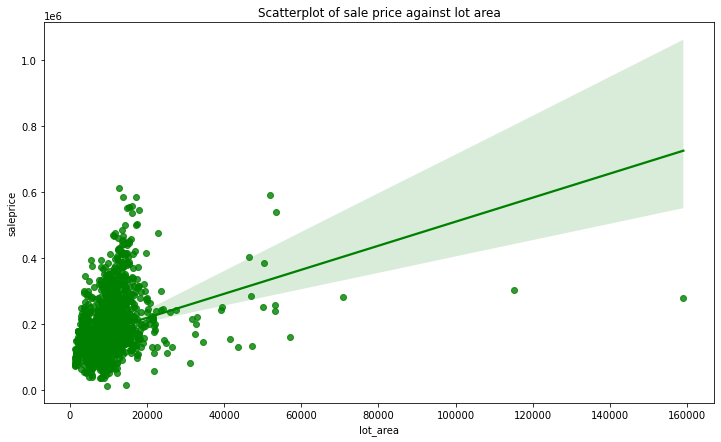

In [154]:
plt.figure(figsize=(12, 7))
plt.title("Scatterplot of sale price against lot area")
sns.regplot(x=train["lot_area"], y=train["saleprice"], color="g");

There are a few obvious outliers in the lot frontage variable. We can try to plot the feature out to look at its properties.

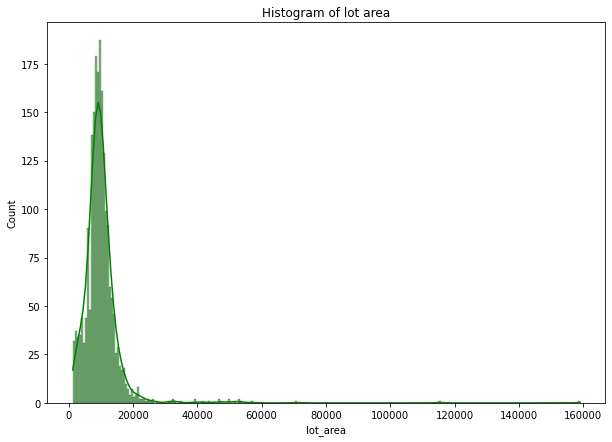

In [155]:
plt.figure(figsize=(10, 7))
plt.title("Histogram of lot area")
sns.histplot(x=train["lot_area"], color="g", kde=True);

In [156]:
normaltest(train["lot_area"])

NormaltestResult(statistic=3198.9991435067686, pvalue=0.0)

The normal test shows that it is not normal at all, and heavily skewed again. This can be more clearly seen in a boxplot.

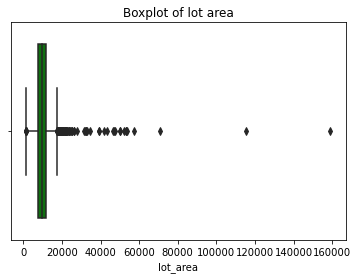

In [157]:
plt.title("Boxplot of lot area")
sns.boxplot(x=train["lot_area"], color="g");

We can perform a winsorization again to handle the outliers.

In [158]:
train_ohe["law"] = winsorize(train["lot_area"], limits=0.05)

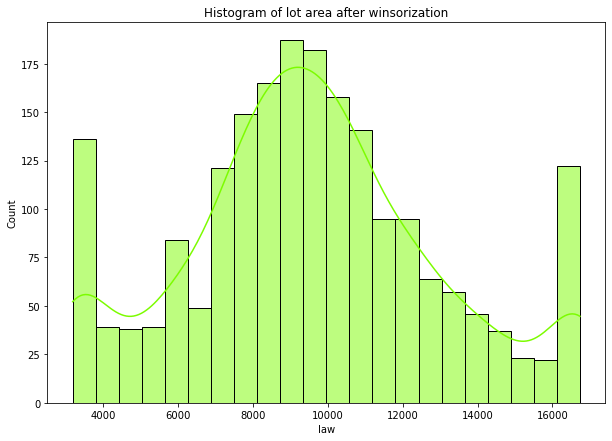

In [159]:
plt.figure(figsize=(10, 7))
plt.title("Histogram of lot area after winsorization")
sns.histplot(x=train_ohe["law"], color="lawngreen", kde=True);

In [160]:
normaltest(train_ohe["law"])

NormaltestResult(statistic=18.332285356295774, pvalue=0.00010451889618724731)

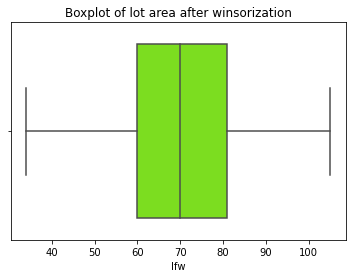

In [161]:
plt.title("Boxplot of lot area after winsorization")
sns.boxplot(x=train_ohe["lfw"], color="lawngreen");

Yet again, the skew is reduced drastically while the p-value was raised significantly. We can do the same thing for lot shape.

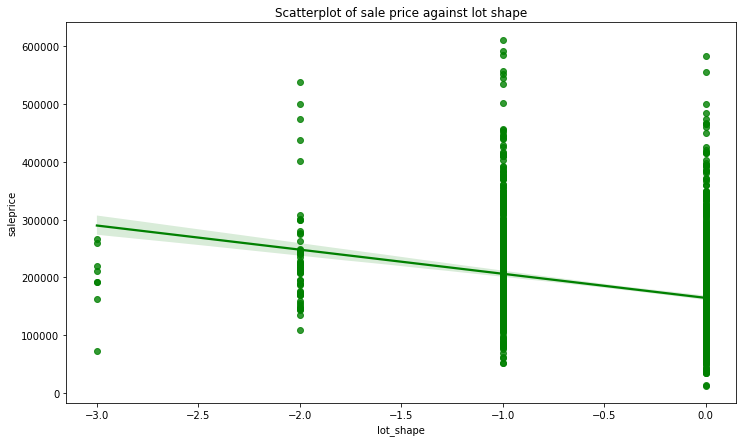

In [162]:
plt.figure(figsize=(12, 7))
plt.title("Scatterplot of sale price against lot shape")
sns.regplot(x=train["lot_shape"], y=train["saleprice"], color="g");

This is an ordinal value which clearly does not follow normalization. We can plot the correlation matrix again with the winsorized values to see if there are any changes to the r-values.

In [163]:
train[["lot_frontage", "lot_area"]] = train_ohe[["lfw", "law"]]

In [164]:
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,land_slope,...,saleprice,logsaleprice,lot_config_Corner,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,lfw,log_lf,law
0,60,RL,87.9,13517,Pave,NA,-1,Lvl,AllPub,Gtl,...,130500,11.779129,0,1,0,0,0,87.9,4.476200,13517
1,60,RL,43.0,11492,Pave,NA,-1,Lvl,AllPub,Gtl,...,220000,12.301383,0,1,0,0,0,43.0,3.761200,11492
2,20,RL,68.0,7922,Pave,NA,0,Lvl,AllPub,Gtl,...,109000,11.599103,0,0,0,0,1,68.0,4.219508,7922
3,60,RL,73.0,9802,Pave,NA,0,Lvl,AllPub,Gtl,...,174000,12.066811,0,0,0,0,1,73.0,4.290459,9802
4,50,RL,82.0,14235,Pave,NA,-1,Lvl,AllPub,Gtl,...,138500,11.838626,0,0,0,0,1,82.0,4.406719,14235


In [165]:
lot_corr = train_ohe.iloc[:, -4:-9:-1]
lot_corr = pd.merge(
    lot_corr,
    train[["lot_frontage", "lot_area", "lot_shape", "logsaleprice"]],
    left_index=True,
    right_index=True,
)
lot_corr.describe().T

,count,mean,std,min,25%,50%,75%,max
lot_config_Inside,2049.0,0.733041,0.442479,0.000000,0.00000,1.000000,1.000000,1.000000
lot_config_FR3,2049.0,0.004392,0.066146,0.000000,0.00000,0.000000,0.000000,1.000000
lot_config_FR2,2049.0,0.029283,0.168639,0.000000,0.00000,0.000000,0.000000,1.000000
lot_config_CulDSac,2049.0,0.063934,0.244694,0.000000,0.00000,0.000000,0.000000,1.000000
lot_config_Corner,2049.0,0.169351,0.375153,0.000000,0.00000,0.000000,0.000000,1.000000
lot_frontage,2049.0,69.378819,18.132779,34.000000,60.00000,70.000000,81.000000,105.000000
lot_area,2049.0,9548.318692,3388.279961,3182.000000,7500.00000,9405.000000,11500.000000,16737.000000
lot_shape,2049.0,-0.402635,0.563725,-3.000000,-1.00000,0.000000,0.000000,0.000000
logsaleprice,2049.0,12.024370,0.411511,9.456341,11.77375,11.998433,12.273731,13.323927


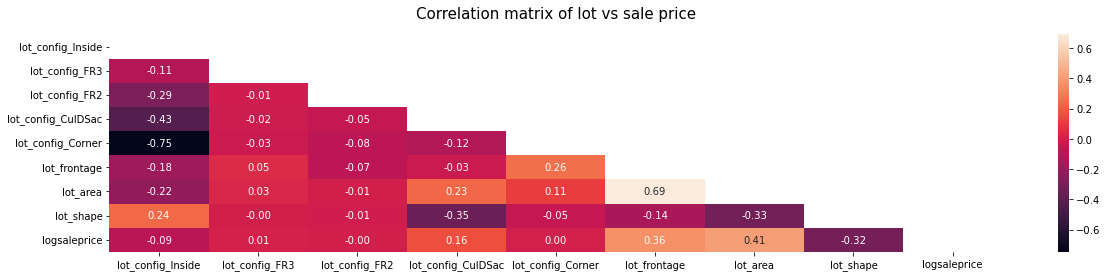

In [166]:
corr = lot_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 4))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of lot vs sale price", fontdict={"fontsize": 15}, pad=16
);

The last three variables have changed, and it seems that they are now better correlated. We will include them in our feature list.

In [167]:
outer_house_data.remove("lot_config")

#### Exterior: exter qual/cond/condition 1/2/exterior 1/2 (ordinal/nominal)

In [168]:
exter = [
    "exter_qual",
    "exter_cond",
    "condition_1",
    "condition_2",
    "exterior_1st",
    "exterior_2nd",
]

In [169]:
for i in exter:
    print(train[i].value_counts())

TA    1247
Gd     697
Ex      79
Fa      26
Name: exter_qual, dtype: int64
TA    1776
Gd     215
Fa      49
Ex       7
Po       2
Name: exter_cond, dtype: int64
Norm      1766
Feedr      108
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: condition_1, dtype: int64
Norm      2023
Feedr       11
Artery       5
PosA         3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: condition_2, dtype: int64
VinylSd    724
MetalSd    331
HdBoard    300
Wd Sdng    276
Plywood    152
CemntBd     89
BrkFace     64
WdShing     45
AsbShng     33
Stucco      26
BrkComm      3
Stone        2
CBlock       2
ImStucc      1
AsphShn      1
Name: exterior_1st, dtype: int64
VinylSd    721
MetalSd    324
HdBoard    275
Wd Sdng    262
Plywood    185
CmentBd     89
Wd Shng     63
BrkFace     34
Stucco      29
AsbShng     28
Brk Cmn     17
ImStucc     11
Stone        6
AsphShn      3
CBlock       2
Name: exterior_2nd, dtype: int64


Let's first convert the ordinals.

In [170]:
exter_dict = asc_ordinal(["Po", "Fa", "TA", "Gd", "Ex"])
train["exter_qual"] = train["exter_qual"].map(exter_dict)
train["exter_cond"] = train["exter_cond"].map(exter_dict)

In [171]:
print(train["exter_qual"].value_counts())
print(train["exter_cond"].value_counts())

2    1247
3     697
4      79
1      26
Name: exter_qual, dtype: int64
2    1776
3     215
1      49
4       7
0       2
Name: exter_cond, dtype: int64


Since there are variables that might be correlated, we can perform a chi-squared test to verify if we can remove one of them.

In [172]:
contingency = pd.crosstab(train["exterior_1st"], train["exterior_2nd"])
chi, p, dof, expected = chi2_contingency(contingency)
p

0.0

In this case, we have a p-value of 0, which means the two variables are exactly dependent, and we can drop the `exterior_2nd` feature. We can perform the same chi-squared test on the condition variables.

In [173]:
contingency = pd.crosstab(train["condition_1"], train["condition_2"])
chi, p, dof, expected = chi2_contingency(contingency)
p

5.872722756489387e-172

These two variables are also dependent. We can then remove `exterior_2nd` and `condition_2`.

In [174]:
outer_house_data.remove("exterior_2nd")
outer_house_data.remove("condition_2")

We can then perform one-hot encoding on the remaining nominal variables and take a look at the heatmap.

In [175]:
train_ohe = pd.get_dummies(train_ohe, columns=["exterior_1st", "condition_1"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,land_slope,...,exterior_1st_WdShing,condition_1_Artery,condition_1_Feedr,condition_1_Norm,condition_1_PosA,condition_1_PosN,condition_1_RRAe,condition_1_RRAn,condition_1_RRNe,condition_1_RRNn
0,60,RL,87.9,13517,Pave,NA,-1,Lvl,AllPub,Gtl,...,0,0,0,0,0,0,1,0,0,0
1,60,RL,43.0,11492,Pave,NA,-1,Lvl,AllPub,Gtl,...,0,0,0,1,0,0,0,0,0,0
2,20,RL,68.0,7922,Pave,NA,0,Lvl,AllPub,Gtl,...,0,0,0,1,0,0,0,0,0,0
3,60,RL,73.0,9802,Pave,NA,0,Lvl,AllPub,Gtl,...,0,0,0,1,0,0,0,0,0,0
4,50,RL,82.0,14235,Pave,NA,-1,Lvl,AllPub,Gtl,...,0,0,0,1,0,0,0,0,0,0


In [176]:
ext_corr = train_ohe.iloc[:, -1:-25:-1]
ext_corr = pd.merge(
    ext_corr,
    train[["exter_qual", "exter_cond", "logsaleprice"]],
    left_index=True,
    right_index=True,
)
ext_corr.head()

,condition_1_RRNn,condition_1_RRNe,condition_1_RRAn,condition_1_RRAe,condition_1_PosN,condition_1_PosA,condition_1_Norm,condition_1_Feedr,condition_1_Artery,exterior_1st_WdShing,...,exterior_1st_HdBoard,exterior_1st_CemntBd,exterior_1st_CBlock,exterior_1st_BrkFace,exterior_1st_BrkComm,exterior_1st_AsphShn,exterior_1st_AsbShng,exter_qual,exter_cond,logsaleprice
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,3,2,11.779129
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,3,2,12.301383
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,3,11.599103
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,2,12.066811
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,2,11.838626


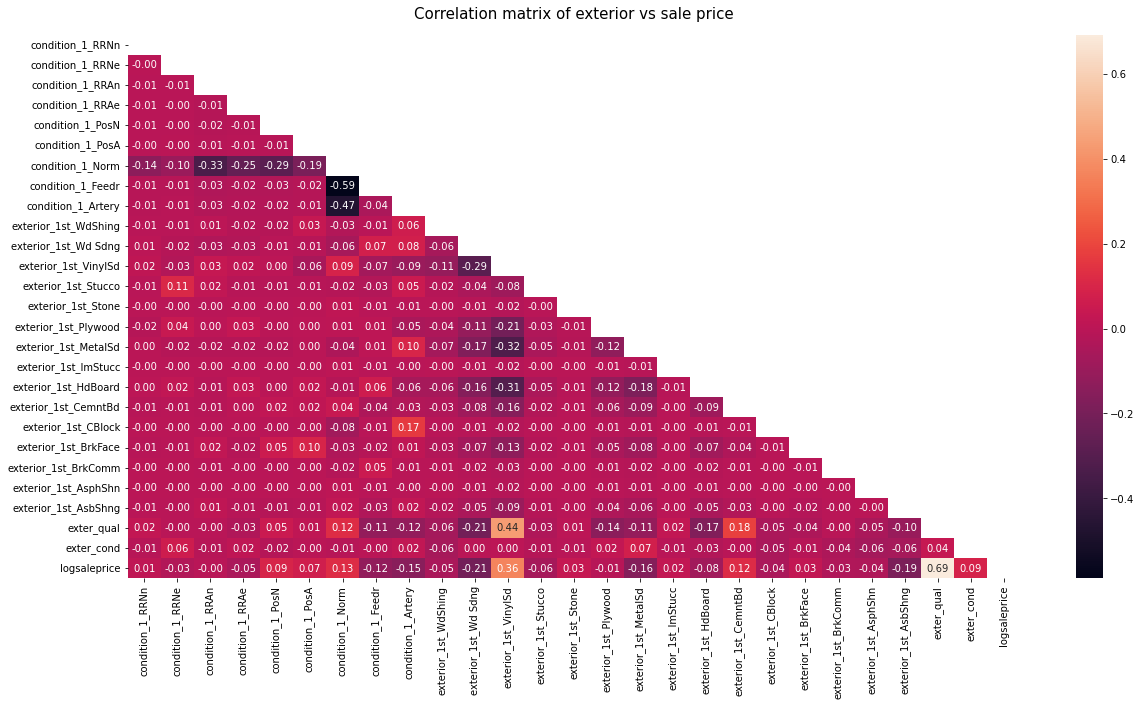

In [177]:
corr = ext_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of exterior vs sale price", fontdict={"fontsize": 15}, pad=16
);

The only variable with a high correlation with the sale price is the quality of the exterior. We can remove all the other variables.

In [178]:
outer_house_data.remove("exter_cond")
outer_house_data.remove("condition_1")
outer_house_data.remove("exterior_1st")

#### Building: bldg type/foundation (nominal)

In [179]:
bldg = ["bldg_type", "foundation"]

In [180]:
for i in bldg:
    print(train[i].value_counts())

1Fam      1698
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: bldg_type, dtype: int64
PConc     924
CBlock    863
BrkTil    221
Slab       34
Stone       5
Wood        2
Name: foundation, dtype: int64


In [181]:
train_ohe = pd.get_dummies(train_ohe, columns=bldg)
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,land_slope,...,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,foundation_BrkTil,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood
0,60,RL,87.9,13517,Pave,NA,-1,Lvl,AllPub,Gtl,...,0,0,0,0,0,1,0,0,0,0
1,60,RL,43.0,11492,Pave,NA,-1,Lvl,AllPub,Gtl,...,0,0,0,0,0,0,1,0,0,0
2,20,RL,68.0,7922,Pave,NA,0,Lvl,AllPub,Gtl,...,0,0,0,0,0,1,0,0,0,0
3,60,RL,73.0,9802,Pave,NA,0,Lvl,AllPub,Gtl,...,0,0,0,0,0,0,1,0,0,0
4,50,RL,82.0,14235,Pave,NA,-1,Lvl,AllPub,Gtl,...,0,0,0,0,0,0,1,0,0,0


In [182]:
bldg_corr = train_ohe.iloc[:, -1:-12:-1]
bldg_corr = pd.merge(
    bldg_corr, train["logsaleprice"], left_index=True, right_index=True
)
bldg_corr.head()

,foundation_Wood,foundation_Stone,foundation_Slab,foundation_PConc,foundation_CBlock,foundation_BrkTil,bldg_type_TwnhsE,bldg_type_Twnhs,bldg_type_Duplex,bldg_type_2fmCon,bldg_type_1Fam,logsaleprice
0,0,0,0,0,1,0,0,0,0,0,1,11.779129
1,0,0,0,1,0,0,0,0,0,0,1,12.301383
2,0,0,0,0,1,0,0,0,0,0,1,11.599103
3,0,0,0,1,0,0,0,0,0,0,1,12.066811
4,0,0,0,1,0,0,0,0,0,0,1,11.838626


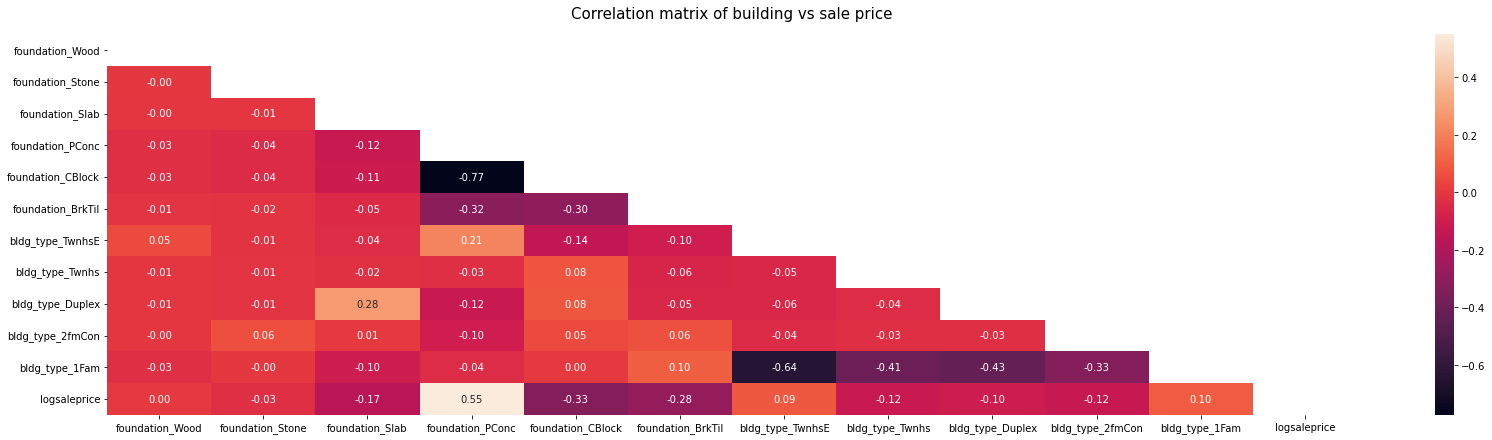

In [183]:
corr = bldg_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(28, 7))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of building vs sale price", fontdict={"fontsize": 15}, pad=16
);

As we can see, only one `foundation` variable has a moderate correlation, but the rest do not. We can drop these features.

In [184]:
for i in bldg:
    outer_house_data.remove(i)

#### Veneer: mas vnr type/area (nominal/continuous)

In [185]:
vnr = ["mas_vnr_type", "mas_vnr_area"]

In [186]:
train_ohe = pd.get_dummies(train_ohe, columns=["mas_vnr_type"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,land_slope,...,foundation_BrkTil,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,mas_vnr_type_BrkCmn,mas_vnr_type_BrkFace,mas_vnr_type_None,mas_vnr_type_Stone
0,60,RL,87.9,13517,Pave,NA,-1,Lvl,AllPub,Gtl,...,0,1,0,0,0,0,0,1,0,0
1,60,RL,43.0,11492,Pave,NA,-1,Lvl,AllPub,Gtl,...,0,0,1,0,0,0,0,1,0,0
2,20,RL,68.0,7922,Pave,NA,0,Lvl,AllPub,Gtl,...,0,1,0,0,0,0,0,0,1,0
3,60,RL,73.0,9802,Pave,NA,0,Lvl,AllPub,Gtl,...,0,0,1,0,0,0,0,0,1,0
4,50,RL,82.0,14235,Pave,NA,-1,Lvl,AllPub,Gtl,...,0,0,1,0,0,0,0,0,1,0


In [187]:
vnr_corr = train_ohe.iloc[:, -1:-4:-1]
vnr_corr = pd.merge(
    vnr_corr, train[["mas_vnr_area", "logsaleprice"]], left_index=True, right_index=True
)
vnr_corr.head()

,mas_vnr_type_Stone,mas_vnr_type_None,mas_vnr_type_BrkFace,mas_vnr_area,logsaleprice
0,0,0,1,289.0,11.779129
1,0,0,1,132.0,12.301383
2,0,1,0,0.0,11.599103
3,0,1,0,0.0,12.066811
4,0,1,0,0.0,11.838626


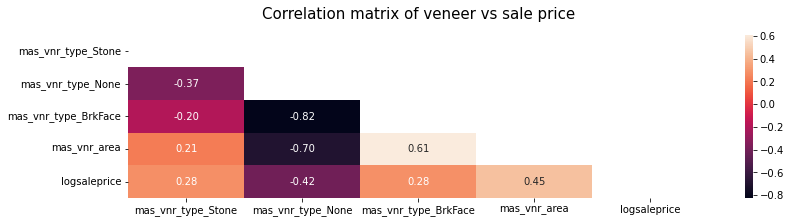

In [188]:
corr = vnr_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(13, 3))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of veneer vs sale price", fontdict={"fontsize": 15}, pad=16
);

The masonry veneer area seems to be moderately correlated. This can be seen to be contrasted with the type 'None', which means that this might be an important variable.

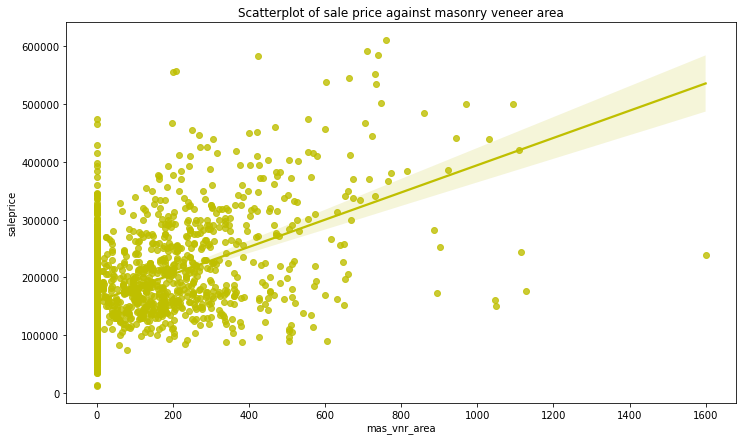

In [189]:
plt.figure(figsize=(12, 7))
plt.title("Scatterplot of sale price against masonry veneer area")
sns.regplot(x=train["mas_vnr_area"], y=train["saleprice"], color="y");

There seems to be a large amount of 0 values, which might adversely affect our analysis. We can take a look at further plots.

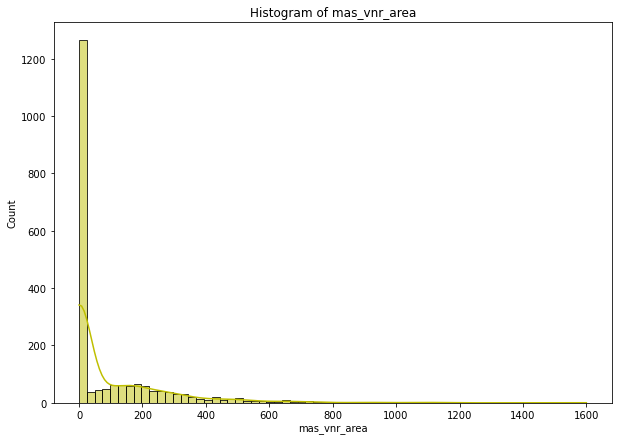

In [190]:
plt.figure(figsize=(10, 7))
plt.title("Histogram of mas_vnr_area")
sns.histplot(x=train["mas_vnr_area"], color="y", kde=True);

In [191]:
normaltest(train["mas_vnr_area"])

NormaltestResult(statistic=1148.6298137848403, pvalue=3.786213170310564e-250)

The normal test shows that it is not normal at all, and heavily skewed due to the presence of many 0 values. This can be more clearly seen in a boxplot.

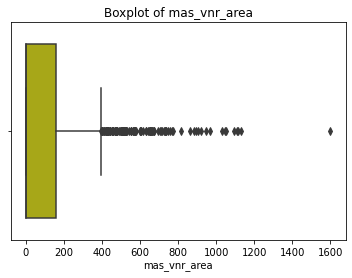

In [192]:
plt.title("Boxplot of mas_vnr_area")
sns.boxplot(x=train["mas_vnr_area"], color="y");

However, since the masonry veneer type is relatively highly correlated to the sale price, we can choose it instead, and remove the area variable with the outliers. We can append the one-hot encoded columns into the `train` dataset.

In [193]:
train[["mas_vnr_stone", "mas_vnr_none", "mas_vnr_brick"]] = train_ohe[
    ["mas_vnr_type_Stone", "mas_vnr_type_None", "mas_vnr_type_BrkFace"]
]

In [194]:
outer_house_data.remove("mas_vnr_area")
outer_house_data.remove("mas_vnr_type")
outer_house_data.append("mas_vnr_stone")
outer_house_data.append("mas_vnr_none")
outer_house_data.append("mas_vnr_brick")

#### Drive: paved drive (ordinal)

In [195]:
train["paved_drive"].value_counts()

Y    1859
N     151
P      39
Name: paved_drive, dtype: int64

This is an ordinal variable, and we can use the functions we have defined above to ordinally encode it.

In [196]:
pave_dict = desc_ordinal(["Y", "N", "P"])
train["paved_drive"] = train["paved_drive"].map(pave_dict)
train["paved_drive"].value_counts()

 0    1859
-1     151
-2      39
Name: paved_drive, dtype: int64

In [197]:
train[["paved_drive", "logsaleprice"]].corr()

,paved_drive,logsaleprice
paved_drive,1.000000,0.338634
logsaleprice,0.338634,1.000000


This has a low correlation too, and we will remove it.

In [198]:
outer_house_data.remove("paved_drive")

#### Summary

It seems we are only left with six variables for the outer house features.

In [199]:
outer_house_data

['lot_frontage',
 'lot_area',
 'lot_shape',
 'exter_qual',
 'mas_vnr_stone',
 'mas_vnr_none',
 'mas_vnr_brick']

### Location

In this category, we examine the features of the location of the house. These would also be the important features that affect the prices of the houses, as good neighborhoods provide ideal environments to live in.

In [200]:
loc = ["land_contour", "land_slope", "neighborhood"]

In [201]:
for i in loc:
    print(train[i].value_counts())

Lvl    1843
HLS      85
Bnk      78
Low      43
Name: land_contour, dtype: int64
Gtl    1951
Mod      88
Sev      10
Name: land_slope, dtype: int64
NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker     17
NPkVill     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64


In [202]:
train[loc].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   land_contour  2049 non-null   object
 1   land_slope    2049 non-null   object
 2   neighborhood  2049 non-null   object
dtypes: object(3)
memory usage: 128.6+ KB


The column types of locations are:
- land contour/slope (nominal/ordinal)
- neighborhood (nominal)

We can first encode the ordinal variable.

In [203]:
land_dict = desc_ordinal(["Gtl", "Mod", "Sev"])
train["land_slope"] = train["land_slope"].map(land_dict)
train["land_slope"].value_counts()

 0    1951
-1      88
-2      10
Name: land_slope, dtype: int64

Next, we shall one-hot encode the nominal `land_contour` variable and take a look at the heatmap.

In [204]:
train_ohe = pd.get_dummies(train_ohe, columns=["land_contour"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,utilities,land_slope,neighborhood,...,foundation_Stone,foundation_Wood,mas_vnr_type_BrkCmn,mas_vnr_type_BrkFace,mas_vnr_type_None,mas_vnr_type_Stone,land_contour_Bnk,land_contour_HLS,land_contour_Low,land_contour_Lvl
0,60,RL,87.9,13517,Pave,NA,-1,AllPub,Gtl,Sawyer,...,0,0,0,1,0,0,0,0,0,1
1,60,RL,43.0,11492,Pave,NA,-1,AllPub,Gtl,SawyerW,...,0,0,0,1,0,0,0,0,0,1
2,20,RL,68.0,7922,Pave,NA,0,AllPub,Gtl,NAmes,...,0,0,0,0,1,0,0,0,0,1
3,60,RL,73.0,9802,Pave,NA,0,AllPub,Gtl,Timber,...,0,0,0,0,1,0,0,0,0,1
4,50,RL,82.0,14235,Pave,NA,-1,AllPub,Gtl,SawyerW,...,0,0,0,0,1,0,0,0,0,1


In [205]:
location.remove("land_contour")
location.remove("land_slope")

In [206]:
land_corr = train_ohe.iloc[:, -1:-4:-1]
land_corr = pd.merge(
    land_corr, train[["land_slope", "logsaleprice"]], left_index=True, right_index=True
)
land_corr.head()

,land_contour_Lvl,land_contour_Low,land_contour_HLS,land_slope,logsaleprice
0,1,0,0,0,11.779129
1,1,0,0,0,12.301383
2,1,0,0,0,11.599103
3,1,0,0,0,12.066811
4,1,0,0,0,11.838626


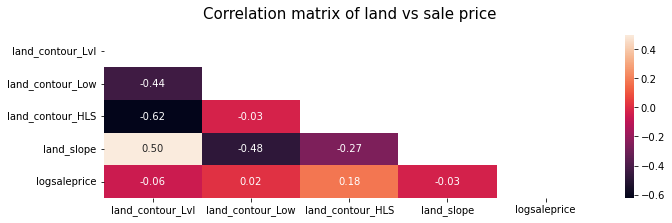

In [207]:
corr = land_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(11, 3))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of land vs sale price", fontdict={"fontsize": 15}, pad=16
);

It seems that these variables have a low correlation. Let's check out the `neighborhood` variable, which should have a high correlation.

In [208]:
len(train["neighborhood"].value_counts())

28

There are 28 neighborhoods listed, which would be too much for a one-hot encoding. However, some of them only have a few observations and might not be statistically significant. We can try to plot some graphs to provide a clearer picture of the neighborhoods. 

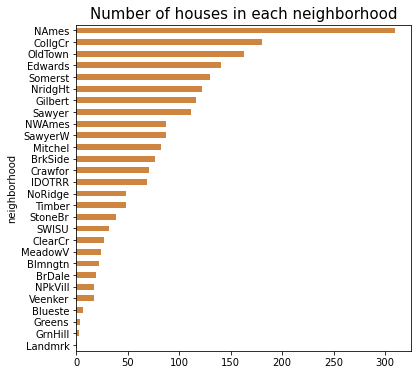

In [209]:
train.groupby("neighborhood").logsaleprice.count().sort_values().plot(
    kind="barh", figsize=(6, 6), color='peru'
)
plt.title("Number of houses in each neighborhood", fontsize=15);

In [210]:
nb_mean = (
    train.groupby("neighborhood", as_index=True)["saleprice"]
    .mean()
    .sort_values(ascending=False)
)
nb_mean

neighborhood
StoneBr    329675.736842
NridgHt    322831.352459
NoRidge    316294.125000
GrnHill    280000.000000
Veenker    253570.588235
Timber     241051.354167
Somerst    227183.900000
ClearCr    217490.074074
Crawfor    205901.211268
CollgCr    202497.216667
Blmngtn    200417.681818
NWAmes     194619.022989
Gilbert    189228.387931
Greens     188666.666667
SawyerW    187760.160920
Mitchel    167656.707317
NAmes      145905.816129
Blueste    144566.666667
NPkVill    140476.470588
Sawyer     137181.909910
Landmrk    137000.000000
SWISU      134758.875000
Edwards    129905.787234
BrkSide    127022.697368
OldTown    125276.300613
BrDale     103371.052632
IDOTRR     101103.188406
MeadowV    100231.250000
Name: saleprice, dtype: float64

As we can see above, the neighborhood variable has a large spread and thus would be difficult to categorize with the absence of a ranking variable. However, given the stratification of data across the different neighborhoods, it might be a prudent to check its correlation with the sale price.

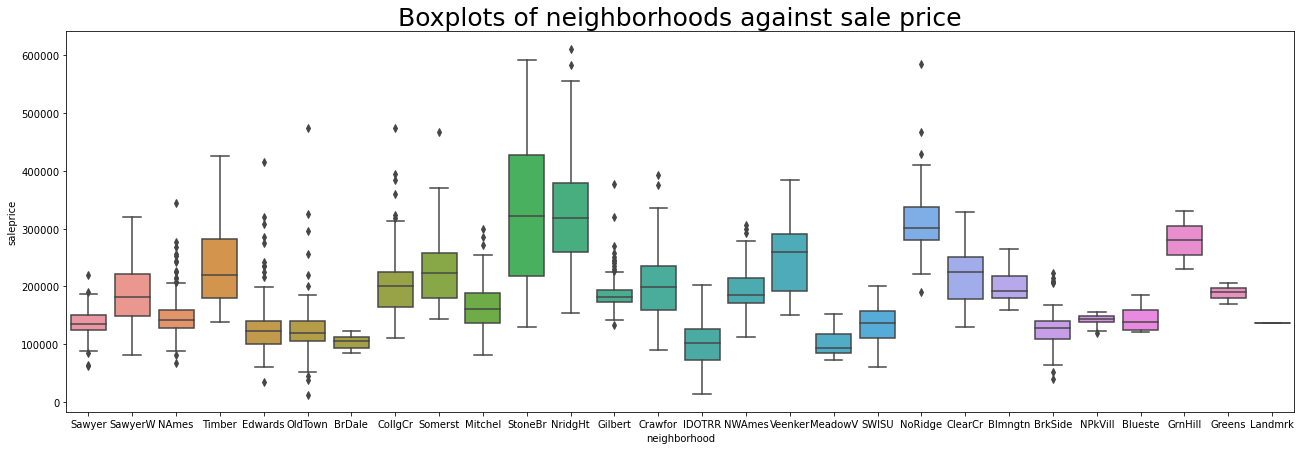

In [211]:
plt.figure(figsize=(22, 7))
sns.boxplot(x=train["neighborhood"], y=train["saleprice"], data=train)
plt.title("Boxplots of neighborhoods against sale price", fontsize=25);

As we can see, the ranges of the neighborhoods are highly stratified. We can create a new variable that ranks the neighborhoods according to the mean housing prices, so that we can have an ordinal variable.

In [212]:
bins = np.linspace(np.floor(min(nb_mean)), np.ceil(max(nb_mean)), 11)
nb_ordinal = []
for i in nb_mean:
    if i < bins[1]:
        nb_ordinal.append(1)
    elif i < bins[2]:
        nb_ordinal.append(2)
    elif i < bins[3]:
        nb_ordinal.append(3)
    elif i < bins[4]:
        nb_ordinal.append(4)
    elif i < bins[5]:
        nb_ordinal.append(5)
    elif i < bins[6]:
        nb_ordinal.append(6)
    elif i < bins[7]:
        nb_ordinal.append(7)
    elif i < bins[8]:
        nb_ordinal.append(8)
    elif i < bins[9]:
        nb_ordinal.append(9)
    else:
        nb_ordinal.append(10)
nb_ordinal = pd.Series(nb_ordinal, index=nb_mean.index)

We have sorted the neighborhoods by ranking of their mean sale prices. We can now ordinally encode the neighborhood variable.

In [213]:
nb_dct = {i: j for i, j in zip(nb_mean.index, nb_ordinal)}
nb_dct

{'StoneBr': 10,
 'NridgHt': 10,
 'NoRidge': 10,
 'GrnHill': 8,
 'Veenker': 7,
 'Timber': 7,
 'Somerst': 6,
 'ClearCr': 6,
 'Crawfor': 5,
 'CollgCr': 5,
 'Blmngtn': 5,
 'NWAmes': 5,
 'Gilbert': 4,
 'Greens': 4,
 'SawyerW': 4,
 'Mitchel': 3,
 'NAmes': 2,
 'Blueste': 2,
 'NPkVill': 2,
 'Sawyer': 2,
 'Landmrk': 2,
 'SWISU': 2,
 'Edwards': 2,
 'BrkSide': 2,
 'OldTown': 2,
 'BrDale': 1,
 'IDOTRR': 1,
 'MeadowV': 1}

In [214]:
train_ohe["neighborhood"] = train_ohe["neighborhood"].map(nb_dct)
train_ohe.neighborhood.value_counts()

2     857
5     360
10    208
4     206
6     157
1     112
3      82
7      65
8       2
Name: neighborhood, dtype: int64

In [215]:
train_ohe[["neighborhood", "logsaleprice"]].corr()

,neighborhood,logsaleprice
neighborhood,1.000000,0.731007
logsaleprice,0.731007,1.000000


The correlation is high, and this would be an important feature for our model. We will convert the training data.

In [216]:
train["neighborhood"] = train["neighborhood"].map(nb_dct)
train_ohe.neighborhood.value_counts()

2     857
5     360
10    208
4     206
6     157
1     112
3      82
7      65
8       2
Name: neighborhood, dtype: int64

### Deck/porch

In this category, we examine the features of the exterior of the house. These would also be the important features that affect the prices of the houses.

In [217]:
deck = ["wood_deck_sf", "open_porch_sf", "enclosed_porch", "screen_porch", "3ssn_porch"]

In [218]:
train[deck].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   wood_deck_sf    2049 non-null   int64
 1   open_porch_sf   2049 non-null   int64
 2   enclosed_porch  2049 non-null   int64
 3   screen_porch    2049 non-null   int64
 4   3ssn_porch      2049 non-null   int64
dtypes: int64(5)
memory usage: 160.6 KB


The column types of deck/porch are all continuous.

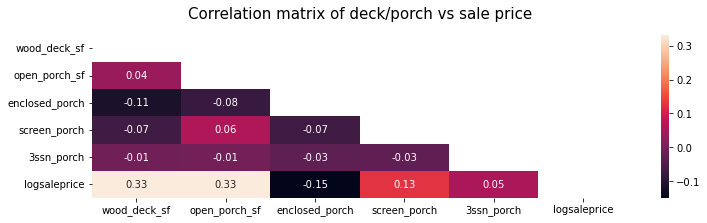

In [219]:
corr = pd.merge(
    train[deck], train["logsaleprice"], left_index=True, right_index=True
).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 3))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of deck/porch vs sale price", fontdict={"fontsize": 15}, pad=16
);

There are no features that stand out. We will ignore them.

In [220]:
deck_porch.clear()

### Basement

In this category, we examine the features of the basement. These might be important features.

The column types of basement are:
- bsmt qual/cond/exposure (ordinal)
- bsmtfin type 1/type 2/sf 1/sf 2/bsmt unf sf/ total bsmt sf (continuous)
- bsmt full bath/ half bath (discrete)

#### Basement quality: bsmt qual/cond/exposure (ordinal)

In [221]:
bqual = ["bsmt_qual", "bsmt_cond", "bsmt_exposure"]

In [222]:
train[bqual].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   bsmt_qual      2049 non-null   int64 
 1   bsmt_cond      1994 non-null   object
 2   bsmt_exposure  1991 non-null   object
dtypes: int64(1), object(2)
memory usage: 128.6+ KB


It would seem that there are a few missing values, but that would simply indicate that there are houses with no basements. These do not affect the analysis, and we can leave them.

In [223]:
for i in bqual:
    print(train[i].value_counts())

3    887
4    864
5    182
2     60
0     55
1      1
Name: bsmt_qual, dtype: int64
TA    1832
Gd      89
Fa      65
Po       5
Ex       3
Name: bsmt_cond, dtype: int64
No    1339
Av     288
Gd     201
Mn     163
Name: bsmt_exposure, dtype: int64


Let's convert the ordinals.

In [224]:
train["bsmt_cond"] = train["bsmt_cond"].map(bsmt_dict)
train["bsmt_cond"].value_counts()

3    1832
4      89
2      65
0      55
1       5
5       3
Name: bsmt_cond, dtype: int64

In [225]:
bsmt_dict2 = asc_ordinal(["No", "Mn", "Av", "Gd"])
train["bsmt_exposure"] = train["bsmt_exposure"].map(bsmt_dict2)
train["bsmt_exposure"].value_counts()

0.0    1339
2.0     288
3.0     201
1.0     163
Name: bsmt_exposure, dtype: int64

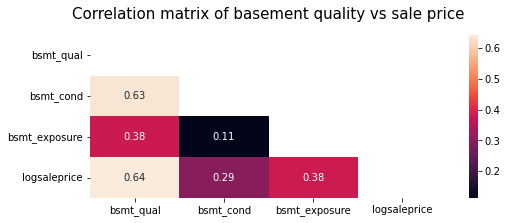

In [226]:
corr = pd.merge(
    train[bqual], train["logsaleprice"], left_index=True, right_index=True
).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 3))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of basement quality vs sale price",
    fontdict={"fontsize": 15},
    pad=16,
);

Apparently the quality of the basement features relatively strongly with the sale price, but not the rest. We can remove the unnecessary features.

In [227]:
for i in range(1, len(bqual)):
    basement.remove(bqual[i])

#### Basement finish: bsmt qual/cond/exposure/unf sf (continuous)

In [228]:
bfin = [
    "bsmtfin_type_1",
    "bsmtfin_sf_1",
    "bsmtfin_type_2",
    "bsmtfin_sf_2",
    "bsmt_unf_sf",
    "total_bsmt_sf",
]

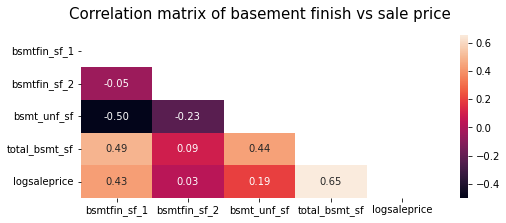

In [229]:
corr = pd.merge(
    train[bfin], train["logsaleprice"], left_index=True, right_index=True
).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 3))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of basement finish vs sale price",
    fontdict={"fontsize": 15},
    pad=16,
);

Only the basement finished square feet 1 and the total basement square feet stand out. However, it would make more sense to take into account the total square feet. We will remove the rest.

In [230]:
for i in range(0, len(bfin) - 1):
    basement.remove(bfin[i])

#### Basement bath: bsmt qual/cond/exposure/unf sf (discrete)

In [231]:
bbath = ["bsmt_full_bath", "bsmt_half_bath"]

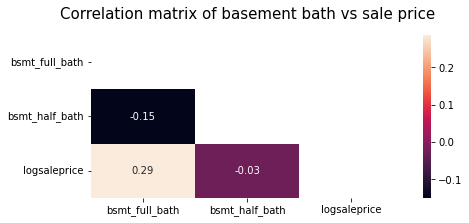

In [232]:
corr = pd.merge(
    train[bbath], train["logsaleprice"], left_index=True, right_index=True
).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(7, 3))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)
heatmap.set_title(
    "Correlation matrix of basement bath vs sale price",
    fontdict={"fontsize": 15},
    pad=16,
);

None of these variables stand out. We will remove them.

In [233]:
for i in bbath:
    basement.remove(i)

#### Summary

We are left with one important variable from this round of cleaning.

In [234]:
basement

['bsmt_qual', 'total_bsmt_sf']

### Garage

In this category, we examine the features of the garage. These, like the basement, would be secondary important features.

In [235]:
garage = [
    "garage_type",
    "garage_yr_blt",
    "garage_finish",
    "garage_cars",
    "garage_area",
    "garage_qual",
    "garage_cond",
]

In [236]:
train[garage].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   garage_type    1936 non-null   object 
 1   garage_yr_blt  2049 non-null   float64
 2   garage_finish  2049 non-null   int64  
 3   garage_cars    2048 non-null   float64
 4   garage_area    2048 non-null   float64
 5   garage_qual    1935 non-null   object 
 6   garage_cond    1935 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 192.6+ KB


Similar to the basement, the garage is an additional add-on which we can consider the null values as the houses having no garage. This again would not adversely impact our analysis.

The column types of garage are:
- garage type/yr blt/finish/cars/area/qual/cond (nominal/discrete/ordinal/discrete/continuous/ordinal/ordinal)

In [237]:
for i in garage:
    print(train[i].value_counts())

Attchd     1211
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: garage_type, dtype: int64
1978.0    147
2005.0    105
2007.0     85
2006.0     80
2004.0     72
         ... 
1896.0      1
1918.0      1
1933.0      1
1895.0      1
1919.0      1
Name: garage_yr_blt, Length: 99, dtype: int64
1    849
2    579
3    507
0    114
Name: garage_finish, dtype: int64
2.0    1135
1.0     524
3.0     262
0.0     113
4.0      13
5.0       1
Name: garage_cars, dtype: int64
0.0      113
440.0     70
576.0     69
484.0     52
528.0     46
        ... 
439.0      1
535.0      1
399.0      1
859.0      1
217.0      1
Name: garage_area, Length: 512, dtype: int64
TA    1830
Fa      82
Gd      18
Ex       3
Po       2
Name: garage_qual, dtype: int64
TA    1866
Fa      47
Gd      12
Po       8
Ex       2
Name: garage_cond, dtype: int64


We can start by converting the ordinal columns.

In [238]:
bsmt_dict = asc_ordinal(["Po", "Fa", "TA", "Gd", "Ex"])
train["garage_cond"] = train["garage_cond"].map(bsmt_dict)
train["garage_cond"].value_counts()

2.0    1866
1.0      47
3.0      12
0.0       8
4.0       2
Name: garage_cond, dtype: int64

In [239]:
train["garage_qual"] = train["garage_qual"].map(bsmt_dict)
train["garage_qual"].value_counts()

2.0    1830
1.0      82
3.0      18
4.0       3
0.0       2
Name: garage_qual, dtype: int64

Next, we can one-hot encode the nominal variable.

In [240]:
train_ohe = pd.get_dummies(train, columns=["garage_type"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,logsaleprice,mas_vnr_stone,mas_vnr_none,mas_vnr_brick,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd
0,60,RL,87.9,13517,Pave,NA,-1,Lvl,AllPub,CulDSac,...,11.779129,0,0,1,0,1,0,0,0,0
1,60,RL,43.0,11492,Pave,NA,-1,Lvl,AllPub,CulDSac,...,12.301383,0,0,1,0,1,0,0,0,0
2,20,RL,68.0,7922,Pave,NA,0,Lvl,AllPub,Inside,...,11.599103,0,1,0,0,0,0,0,0,1
3,60,RL,73.0,9802,Pave,NA,0,Lvl,AllPub,Inside,...,12.066811,0,1,0,0,0,0,1,0,0
4,50,RL,82.0,14235,Pave,NA,-1,Lvl,AllPub,Inside,...,11.838626,0,1,0,0,0,0,0,0,1


We can also convert the year the garage was built to its actual age for it to be easier to work with.

In [241]:
train_ohe["garage_yr_blt"] = pd.to_datetime(
    train["garage_yr_blt"], format="%Y", errors="coerce"
)
train["garage_age"] = (now - train_ohe["garage_yr_blt"]).astype("<m8[Y]")
train[["garage_yr_blt", "garage_age"]].head()

,garage_yr_blt,garage_age
0,1976.0,46.0
1,1997.0,25.0
2,1953.0,69.0
3,2007.0,15.0
4,1957.0,65.0


In [242]:
gar_corr = train_ohe.iloc[:, -1:-6:-1]
gar_corr = pd.merge(
    gar_corr,
    train[
        [
            "garage_yr_blt",
            "garage_age",
            "garage_finish",
            "garage_cars",
            "garage_area",
            "garage_qual",
            "garage_cond",
            "logsaleprice",
        ]
    ],
    left_index=True,
    right_index=True,
)
gar_corr.head()

,garage_type_Detchd,garage_type_CarPort,garage_type_BuiltIn,garage_type_Basment,garage_type_Attchd,garage_yr_blt,garage_age,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,logsaleprice
0,0,0,0,0,1,1976.0,46.0,2,2.0,475.0,2.0,2.0,11.779129
1,0,0,0,0,1,1997.0,25.0,2,2.0,559.0,2.0,2.0,12.301383
2,1,0,0,0,0,1953.0,69.0,1,1.0,246.0,2.0,2.0,11.599103
3,0,0,1,0,0,2007.0,15.0,3,2.0,400.0,2.0,2.0,12.066811
4,1,0,0,0,0,1957.0,65.0,1,2.0,484.0,2.0,2.0,11.838626


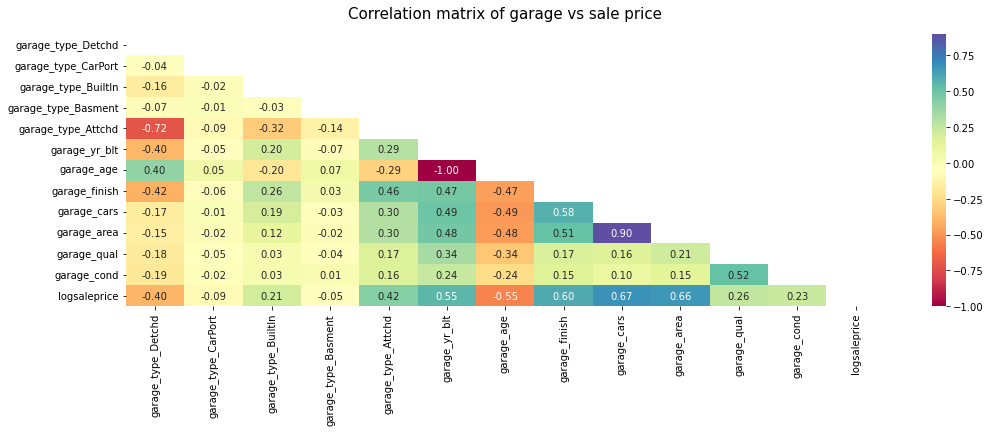

In [243]:
corr = gar_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(17, 5))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap="Spectral")
heatmap.set_title(
    "Correlation matrix of garage vs sale price", fontdict={"fontsize": 15}, pad=16
);

There are some interesting correlations here, namely the age of the garage, the number of cars that can fit, the area of the garage, and the finish of the garage.

Since the number of cars that can fit in a garage is similar to the area of a garage, we can perform a chi-squared test to verify this. These variables are dependent, so we can drop the garage area.

In [244]:
contingency = pd.crosstab(train["garage_cars"], train["garage_area"])
chi, p, dof, expected = chi2_contingency(contingency)
p

0.0

In [245]:
garage.remove("garage_type")
garage.remove("garage_area")
garage.remove("garage_qual")
garage.remove("garage_cond")
garage.remove("garage_yr_blt")
garage.append("garage_age")

### History

In this category, we examine historical properties of the house. These would be of importance in determining the housing prices - if not for a direct correlation then at least for grouping.

In [246]:
history = ["mo_sold", "yr_sold", "year_built", "year_remod/add", "sale_type"]

In [247]:
train[history].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   mo_sold         2049 non-null   int64 
 1   yr_sold         2049 non-null   int64 
 2   year_built      2049 non-null   int64 
 3   year_remod/add  2049 non-null   int64 
 4   sale_type       2049 non-null   object
dtypes: int64(4), object(1)
memory usage: 160.6+ KB


The column types for history are:
- mo/yr sold/year built/year remod/add (discrete)
- sale type (nominal)

We can first create columns to keep track of the age of the houses, rather than the raw years.

In [248]:
train_ohe["yr_built_dt"] = pd.to_datetime(train["year_built"], format="%Y")
train["house_age"] = (now - train_ohe["yr_built_dt"]).astype("<m8[Y]")
train[["year_built", "house_age"]].head(10)

,year_built,house_age
0,1976,46.0
1,1996,26.0
2,1953,69.0
3,2006,16.0
4,1900,122.0
5,1966,56.0
6,2005,17.0
7,1959,63.0
8,1952,70.0
9,1969,53.0


In [249]:
train_ohe["yr_sold_dt"] = pd.to_datetime(train["yr_sold"], format="%Y")
train["sold_years"] = (train_ohe["yr_built_dt"] - train_ohe["yr_sold_dt"]).astype("<m8[Y]")
train[["yr_sold", "sold_years"]].head()

,yr_sold,sold_years
0,2010,-35.0
1,2009,-14.0
2,2010,-58.0
3,2010,-5.0
4,2010,-111.0


In [250]:
train_ohe["yr_rm_dt"] = pd.to_datetime(train["year_remod/add"], format="%Y")
train["remod_years"] = (now - train_ohe["yr_rm_dt"]).astype("<m8[Y]")
train[["year_remod/add", "remod_years"]].head()

,year_remod/add,remod_years
0,2005,17.0
1,1997,25.0
2,2007,15.0
3,2007,15.0
4,1993,29.0


We can ignore the month sold because it is too granular a feature and might cause overfitting. Now we can plot a heatmap for our brand new variables.

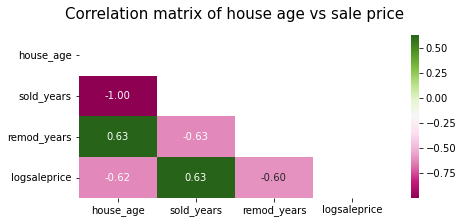

In [251]:
corr = train[["house_age", "sold_years", "remod_years", "logsaleprice"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(7, 3))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap="PiYG")
heatmap.set_title(
    "Correlation matrix of house age vs sale price", fontdict={"fontsize": 15}, pad=16
);

Unsurprisingly, the age of the house and the number of years since remodelling affects the house price moderately inversely - the younger the house the more expensive it is. We can do some editing of the history variable.

We can one-hot encode the nominal variable.

In [252]:
train_ohe = pd.get_dummies(train_ohe, columns=["sale_type"])
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,yr_rm_dt,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD
0,60,RL,87.9,13517,Pave,NA,-1,Lvl,AllPub,CulDSac,...,2005-01-01,0,0,0,0,0,0,0,0,1
1,60,RL,43.0,11492,Pave,NA,-1,Lvl,AllPub,CulDSac,...,1997-01-01,0,0,0,0,0,0,0,0,1
2,20,RL,68.0,7922,Pave,NA,0,Lvl,AllPub,Inside,...,2007-01-01,0,0,0,0,0,0,0,0,1
3,60,RL,73.0,9802,Pave,NA,0,Lvl,AllPub,Inside,...,2007-01-01,0,0,0,0,0,0,0,0,1
4,50,RL,82.0,14235,Pave,NA,-1,Lvl,AllPub,Inside,...,1993-01-01,0,0,0,0,0,0,0,0,1


In [253]:
sale_corr = train_ohe.iloc[:, -1:-10:-1]
sale_corr = pd.merge(
    sale_corr, train["logsaleprice"], left_index=True, right_index=True
)
sale_corr.head()

,sale_type_WD,sale_type_Oth,sale_type_New,sale_type_ConLw,sale_type_ConLI,sale_type_ConLD,sale_type_Con,sale_type_CWD,sale_type_COD,logsaleprice
0,1,0,0,0,0,0,0,0,0,11.779129
1,1,0,0,0,0,0,0,0,0,12.301383
2,1,0,0,0,0,0,0,0,0,11.599103
3,1,0,0,0,0,0,0,0,0,12.066811
4,1,0,0,0,0,0,0,0,0,11.838626


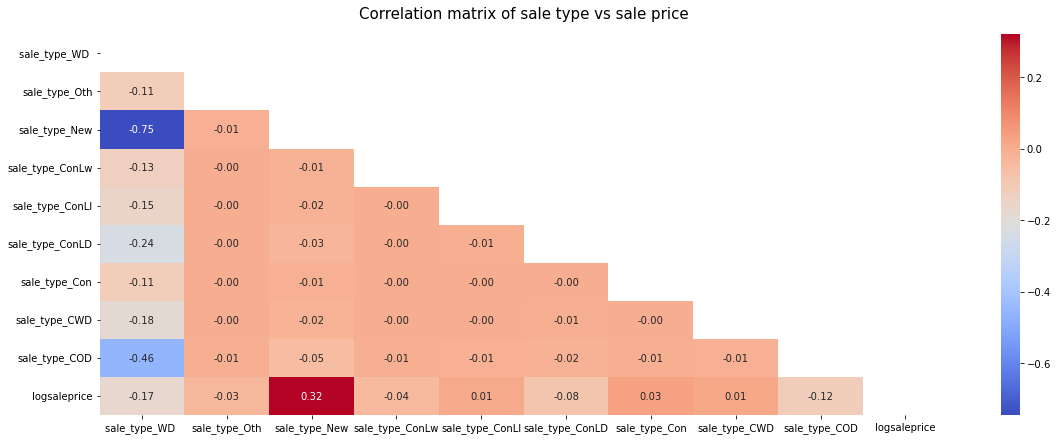

In [254]:
corr = sale_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(19, 7))
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap="coolwarm")
heatmap.set_title(
    "Correlation matrix of sale type vs sale price", fontdict={"fontsize": 15}, pad=16
);

None of the `sale_type` variables are strongly correlated. We can remove it.

In [255]:
history.remove("year_built")
history.remove("mo_sold")
history.remove("yr_sold")
history.remove("year_remod/add")
history.remove("sale_type")
history.append('sold_years')
history.append("house_age")
history.append("remod_years")

In [256]:
history

['sold_years', 'house_age', 'remod_years']

### Summary

We can now do a summary to see how many variables we have left.

In [257]:
# check whether all the variables have been captured
len(inner_house_data) + len(outer_house_data) + len(location) + len(deck_porch) + len(
    basement
) + len(garage) + len(history)

24

In [258]:
final_cols = (
    inner_house_data
    + outer_house_data
    + location
    + deck_porch
    + basement
    + garage
    + history
)
final_cols

['overall_qual',
 'heating_qc',
 'gr_liv_area',
 'full_bath',
 'kitchen_qual',
 'totrms_abvgrd',
 'fireplaces',
 'fireplace_qu',
 'lot_frontage',
 'lot_area',
 'lot_shape',
 'exter_qual',
 'mas_vnr_stone',
 'mas_vnr_none',
 'mas_vnr_brick',
 'neighborhood',
 'bsmt_qual',
 'total_bsmt_sf',
 'garage_finish',
 'garage_cars',
 'garage_age',
 'sold_years',
 'house_age',
 'remod_years']

We can afford a few more columns which we can add back in based on domain knowledge. We have to also consider the p-value in case the model might be overfit. These would include:
- `central_air` (p=0.32)

and of course, the dependent variable.

In [259]:
final_cols.append("central_air")
final_cols.append("logsaleprice")

In [260]:
train[final_cols].head()

,overall_qual,heating_qc,gr_liv_area,full_bath,kitchen_qual,totrms_abvgrd,fireplaces,fireplace_qu,lot_frontage,lot_area,...,bsmt_qual,total_bsmt_sf,garage_finish,garage_cars,garage_age,sold_years,house_age,remod_years,central_air,logsaleprice
0,6,4,1479,2,2,6,0,0,87.9,13517,...,3,725.0,2,2.0,46.0,-35.0,46.0,17.0,1,11.779129
1,7,4,2122,2,2,8,1,3,43.0,11492,...,4,913.0,2,2.0,25.0,-14.0,26.0,25.0,1,12.301383
2,5,2,1057,1,2,5,0,0,68.0,7922,...,3,1057.0,1,1.0,69.0,-58.0,69.0,15.0,1,11.599103
3,5,3,1444,2,1,7,0,0,73.0,9802,...,4,384.0,3,2.0,15.0,-5.0,16.0,15.0,1,12.066811
4,6,2,1445,2,1,6,0,0,82.0,14235,...,2,676.0,1,2.0,65.0,-111.0,122.0,29.0,1,11.838626


In [261]:
train[final_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2050
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   overall_qual   2049 non-null   int64  
 1   heating_qc     2049 non-null   int64  
 2   gr_liv_area    2049 non-null   int64  
 3   full_bath      2049 non-null   int64  
 4   kitchen_qual   2049 non-null   int64  
 5   totrms_abvgrd  2049 non-null   int64  
 6   fireplaces     2049 non-null   int64  
 7   fireplace_qu   2049 non-null   int64  
 8   lot_frontage   2049 non-null   float64
 9   lot_area       2049 non-null   int64  
 10  lot_shape      2049 non-null   int64  
 11  exter_qual     2049 non-null   int64  
 12  mas_vnr_stone  2049 non-null   uint8  
 13  mas_vnr_none   2049 non-null   uint8  
 14  mas_vnr_brick  2049 non-null   uint8  
 15  neighborhood   2049 non-null   int64  
 16  bsmt_qual      2049 non-null   int64  
 17  total_bsmt_sf  2048 non-null   float64
 18  garage_f

With these 25 features, we are finally done with data cleaning. However, there is still 1 pesky missing data in `total_bsmt_sf` and `garage_cars`. We will assume that that house has no basement or garage, and impute 0 for the null value.

In [262]:
train["total_bsmt_sf"].fillna(0, inplace=True)
train["garage_cars"].fillna(0, inplace=True)

Let's take a final look at the correlations between the features and the sale price.

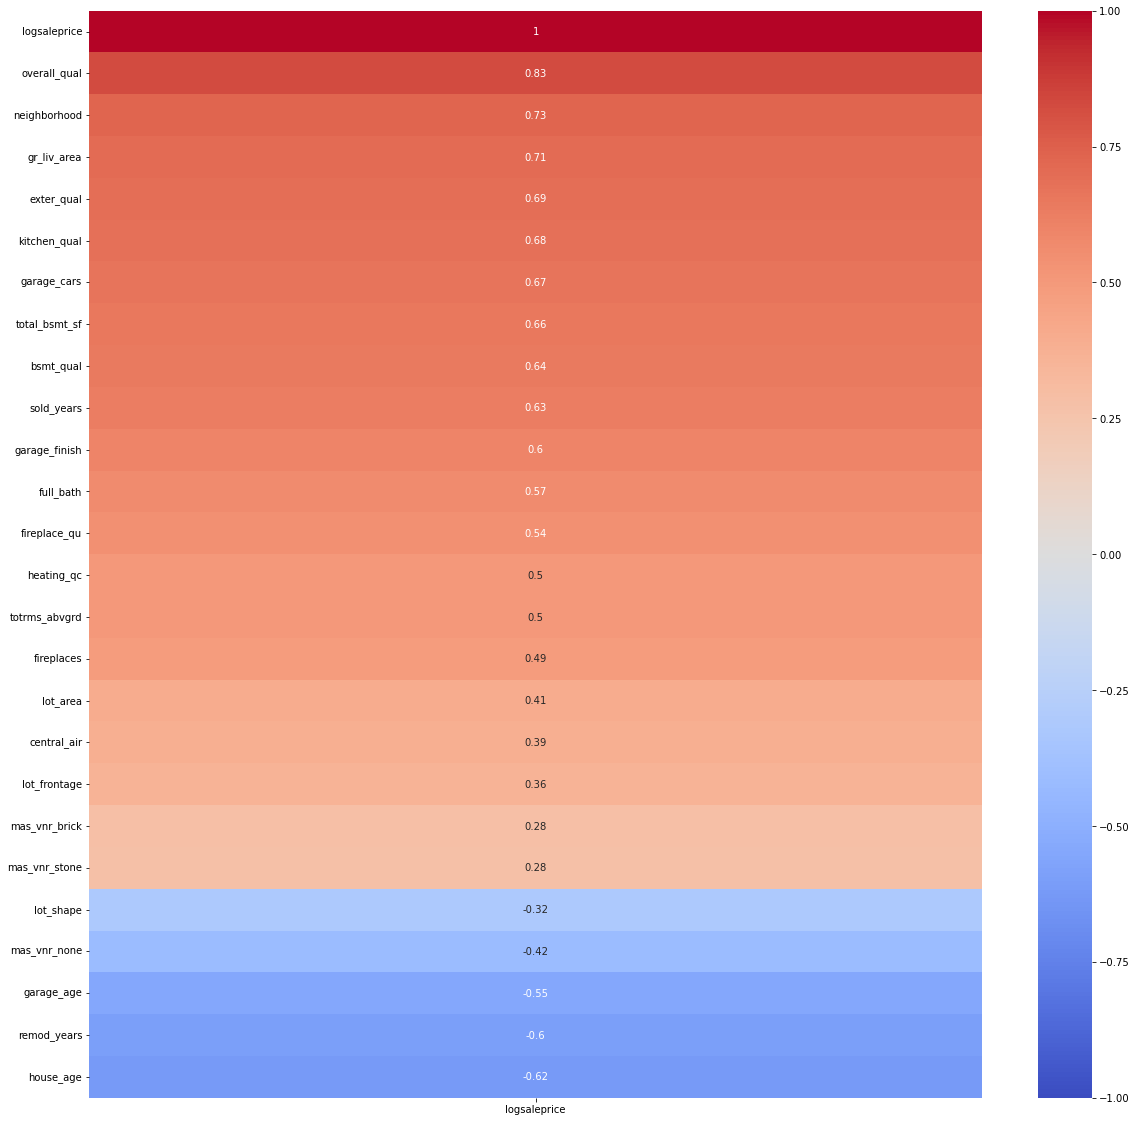

In [263]:
plt.figure(figsize = (20, 20))
sns.heatmap(train[final_cols].corr()[['logsaleprice']].sort_values('logsaleprice', ascending = False), 
            annot=True, cmap ='coolwarm', 
            vmin=-1, vmax=1);

# Cleaning `test`

In [263]:
train.columns.difference(test.columns)

Index(['garage_age', 'house_age', 'logsaleprice', 'mas_vnr_brick',
       'mas_vnr_none', 'mas_vnr_stone', 'remod_years', 'saleprice',
       'sold_years'],
      dtype='object')

These were the features we added to the `train` dataset, and we have to add them to the `test` ones too. We first take a look at the `test` dataset.

In [264]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ms_subclass      878 non-null    int64  
 1   ms_zoning        878 non-null    object 
 2   lot_frontage     718 non-null    float64
 3   lot_area         878 non-null    int64  
 4   street           878 non-null    object 
 5   alley            58 non-null     object 
 6   lot_shape        878 non-null    object 
 7   land_contour     878 non-null    object 
 8   utilities        878 non-null    object 
 9   lot_config       878 non-null    object 
 10  land_slope       878 non-null    object 
 11  neighborhood     878 non-null    object 
 12  condition_1      878 non-null    object 
 13  condition_2      878 non-null    object 
 14  bldg_type        878 non-null    object 
 15  house_style      878 non-null    object 
 16  overall_qual     878 non-null    int64  
 17  overall_cond    

## Changing datetimes

We first create the `garage_age` feature. We will again input the mean year for the missing values so the function will not throw an error or unnecessarily delete rows.

In [265]:
test["garage_yr_blt"].mean()

1976.7599039615845

In [266]:
test["garage_yr_blt"].fillna(1976, inplace=True)
train.garage_yr_blt.value_counts().sort_values()

1919.0      1
1917.0      1
1896.0      1
1895.0      1
1933.0      1
         ... 
2004.0     72
2006.0     80
2007.0     85
2005.0    105
1978.0    147
Name: garage_yr_blt, Length: 99, dtype: int64

In [267]:
test["garage_yr_blt"] = pd.to_datetime(test["garage_yr_blt"], format="%Y")
test["garage_age"] = (now - test["garage_yr_blt"]).astype("<m8[Y]")
test[["garage_yr_blt", "garage_age"]].head()

,garage_yr_blt,garage_age
0,1910-01-01,112.0
1,1977-01-01,45.0
2,2006-01-01,16.0
3,1935-01-01,87.0
4,1963-01-01,59.0


We can do the same thing for `house_age` and `remod_years`.

In [268]:
test["yr_built_dt"] = pd.to_datetime(test["year_built"], format="%Y")
test["house_age"] = (now - test["yr_built_dt"]).astype("<m8[Y]")
test[["year_built", "house_age"]].head()

,year_built,house_age
0,1910,112.0
1,1977,45.0
2,2006,16.0
3,1923,99.0
4,1963,59.0


In [269]:
test["yr_rm_dt"] = pd.to_datetime(test["year_remod/add"], format="%Y")
test["remod_years"] = (now - test["yr_rm_dt"]).astype("<m8[Y]")
test[["year_remod/add", "remod_years"]].head()

,year_remod/add,remod_years
0,1950,72.0
1,1977,45.0
2,2006,16.0
3,2006,16.0
4,1963,59.0


In [270]:
test["yr_sold_dt"] = pd.to_datetime(test["yr_sold"], format="%Y")
test["sold_years"] = (now - test["yr_sold_dt"]).astype("<m8[Y]")
test[["yr_sold", "sold_years"]].head()

,yr_sold,sold_years
0,2006,16.0
1,2006,16.0
2,2006,16.0
3,2007,15.0
4,2009,13.0


We also one-hot encoded our `mas_vnr_type` feature.

In [271]:
train_ohe = pd.get_dummies(test, columns=["mas_vnr_type"], prefix="test")
train_ohe.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,house_age,yr_rm_dt,remod_years,yr_sold_dt,sold_years,test_BrkCmn,test_BrkFace,test_CBlock,test_None,test_Stone
0,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,112.0,1950-01-01,72.0,2006-01-01,16.0,0,0,0,1,0
1,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,...,45.0,1977-01-01,45.0,2006-01-01,16.0,0,0,0,1,0
2,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,...,16.0,2006-01-01,16.0,2006-01-01,16.0,0,0,0,1,0
3,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,...,99.0,2006-01-01,16.0,2007-01-01,15.0,0,0,0,1,0
4,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,...,59.0,1963-01-01,59.0,2009-01-01,13.0,0,1,0,0,0


In [272]:
test[["mas_vnr_stone", "mas_vnr_none", "mas_vnr_brick"]] = train_ohe[
    ["test_Stone", "test_None", "test_BrkFace"]
]

Now we need to remove the `logsaleprice` from our `final_cols` variable, because it is not present in our `test` dataset.

In [273]:
final_cols_test = [final_cols[i] for i in range(0, len(final_cols) - 1)]
final_cols_test

['overall_qual',
 'heating_qc',
 'gr_liv_area',
 'full_bath',
 'kitchen_qual',
 'totrms_abvgrd',
 'fireplaces',
 'fireplace_qu',
 'lot_frontage',
 'lot_area',
 'lot_shape',
 'exter_qual',
 'mas_vnr_stone',
 'mas_vnr_none',
 'mas_vnr_brick',
 'neighborhood',
 'bsmt_qual',
 'total_bsmt_sf',
 'garage_finish',
 'garage_cars',
 'garage_age',
 'sold_years',
 'house_age',
 'remod_years',
 'central_air']

## Ordinal encodings

In [274]:
test[final_cols_test].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   overall_qual   878 non-null    int64  
 1   heating_qc     878 non-null    object 
 2   gr_liv_area    878 non-null    int64  
 3   full_bath      878 non-null    int64  
 4   kitchen_qual   878 non-null    object 
 5   totrms_abvgrd  878 non-null    int64  
 6   fireplaces     878 non-null    int64  
 7   fireplace_qu   456 non-null    object 
 8   lot_frontage   718 non-null    float64
 9   lot_area       878 non-null    int64  
 10  lot_shape      878 non-null    object 
 11  exter_qual     878 non-null    object 
 12  mas_vnr_stone  878 non-null    uint8  
 13  mas_vnr_none   878 non-null    uint8  
 14  mas_vnr_brick  878 non-null    uint8  
 15  neighborhood   878 non-null    object 
 16  bsmt_qual      853 non-null    object 
 17  total_bsmt_sf  878 non-null    int64  
 18  garage_fin

As we can see, some of the columns still need to be ordinal encoded.

In [275]:
test["heating_qc"] = test["heating_qc"].map(heating_qc_dict)
test["heating_qc"].value_counts()

4    429
2    267
3    157
1     25
Name: heating_qc, dtype: int64

In [276]:
test["kitchen_qual"] = test["kitchen_qual"].map(heating_qc_dict)
test["kitchen_qual"].value_counts()

2    447
3    354
4     53
1     23
0      1
Name: kitchen_qual, dtype: int64

In [277]:
test["fireplace_qu"] = test["fireplace_qu"].map(fireplace_qu_dict)
test["fireplace_qu"].value_counts()

0    422
4    220
3    193
2     16
1     15
5     12
Name: fireplace_qu, dtype: int64

In [278]:
test["fireplace_qu"].isnull().sum()

0

In [279]:
lshape_dict = asc_ordinal(["IR3", "IR2", "IR1", "Reg"])
test["lot_shape"] = test["lot_shape"].map(lshape_dict)
test["lot_shape"].value_counts()

3    564
2    286
1     21
0      7
Name: lot_shape, dtype: int64

In [280]:
test["exter_qual"] = test["exter_qual"].map(exter_dict)
test["exter_qual"].value_counts()

2    552
3    292
4     25
1      9
Name: exter_qual, dtype: int64

In [281]:
test["neighborhood"] = test["neighborhood"].map(nb_dct)
test.neighborhood.value_counts()

2     357
5     169
4      92
10     80
6      69
1      48
3      32
7      31
Name: neighborhood, dtype: int64

In [282]:
bsmt_dict = asc_ordinal([np.nan, "Po", "Fa", "TA", "Gd", "Ex"])
test["bsmt_qual"] = test["bsmt_qual"].map(bsmt_dict)
test["bsmt_qual"].value_counts()

3    396
4    355
5     73
2     28
0     25
1      1
Name: bsmt_qual, dtype: int64

In [283]:
test["garage_finish"] = test["garage_finish"].map(gar_dict)
test["garage_finish"].value_counts()

1    382
2    233
3    218
0     45
Name: garage_finish, dtype: int64

In [284]:
test["central_air"] = test["central_air"].map(binary)
test["central_air"].value_counts()

1    823
0     55
Name: central_air, dtype: int64

# Impute missing values

In [285]:
kimpute = KNNImputer(n_neighbors=10)
test["lot_frontage"] = kimpute.fit_transform(
    test[["lot_frontage", "lot_area", "lot_shape"]]
)

In [286]:
test[final_cols_test].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   overall_qual   878 non-null    int64  
 1   heating_qc     878 non-null    int64  
 2   gr_liv_area    878 non-null    int64  
 3   full_bath      878 non-null    int64  
 4   kitchen_qual   878 non-null    int64  
 5   totrms_abvgrd  878 non-null    int64  
 6   fireplaces     878 non-null    int64  
 7   fireplace_qu   878 non-null    int64  
 8   lot_frontage   878 non-null    float64
 9   lot_area       878 non-null    int64  
 10  lot_shape      878 non-null    int64  
 11  exter_qual     878 non-null    int64  
 12  mas_vnr_stone  878 non-null    uint8  
 13  mas_vnr_none   878 non-null    uint8  
 14  mas_vnr_brick  878 non-null    uint8  
 15  neighborhood   878 non-null    int64  
 16  bsmt_qual      878 non-null    int64  
 17  total_bsmt_sf  878 non-null    int64  
 18  garage_fin

# Saving the dataframes

We can save the final dataframes into csv files. We will only take the important columns from our `test` dataset.

In [287]:
train[final_cols].to_csv("datasets/train_clean.csv", index=False)
test[final_cols_test].to_csv("datasets/test_clean.csv", index=False)

# Data Dictionary

|    Feature    | Type    | Description                                                    |
|:-------------:|---------|----------------------------------------------------------------|
| overall_qual  | int64   | ordinal: rates the overall material and finish of the house    |
| heating_qc    | int64   | ordinal: Heating quality and condition                         |
| gr_liv_area   | int64   | continuous: above grade (ground) living area square feet       |
| full_bath     | int64   | discrete: Full bathrooms above grade                           |
| kitchen_qual  | int64   | ordinal: Kitchen quality                                       |
| totrms_abvgrd | int64   | discrete: Total rooms above grade (does not include bathrooms) |
| fireplaces    | int64   | discrete: Number of fireplaces                                 |
| fireplace_qu  | int64   | ordinal: Fireplace quality                                     |
| lot_frontage  | float64 | continuous: Linear feet of street connected to property        |
| lot_area      | int64   | continuous: Lot size in square feet                            |
| lot_shape     | int64   | ordinal: General shape of property                             |
| exter_qual    | int64   | ordinal: Evaluates the quality of the material on the exterior |
| mas_vnr_stone | uint8   | nominal (one-hot): Masonry veneer type (stone)                 |
| mas_vnr_none  | uint8   | nominal (one-hot): Masonry veneer type (none)                  |
| mas_vnr_brick | uint8   | nominal (one-hot): Masonry veneer type (brick)                 |
| neighborhood  | int64   | ordinal: Physical locations within Ames city limits            |
| bsmt_qual     | int64   | ordinal: Evaluates the height of the basement                  |
| total_bsmt_sf | float64 | continuous: Total square feet of basement area                 |
| garage_finish | int64   | ordinal: Interior finish of the garage                         |
| garage_cars   | float64 | discrete: Size of garage in car capacity                       |
| garage_age    | float64 | discrete: age of garage                                        |
| sold_years    | float64 | discrete: years between the building and selling of house      |
| house_age     | float64 | discrete: age of house                                         |
| remod_years   | float64 | discrete: years since remodelling                              |
| central_air   | int64   | binary: whether the house has central air-conditioning         |
| logsaleprice  | float64 | continuous: the natural logarithm of sale price of the house   |